In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

def generate_graph(label, num_points=20, noise_scale=0.01):
    """
    Generates a graph with points near the circumference of a circle (label=0)
    or near the perimeter of a square (label=1).
    """
    if label == 0:
        # Generate points near circumference of a circle with radial noise
        angles = np.random.uniform(0, 2 * np.pi, num_points)
        radial_noise = np.random.normal(scale=noise_scale, size=num_points)
        x_coords = (1 + radial_noise) * np.cos(angles)
        y_coords = (1 + radial_noise) * np.sin(angles)
        coords = np.vstack((x_coords, y_coords)).T
        pos = torch.tensor(coords, dtype=torch.float)
    

    else:
        half_side = 1 / 2
        points = []
        
        for _ in range(num_points):
            edge = np.random.choice(['top', 'bottom', 'left', 'right'])
            if edge in ['top', 'bottom']:
                x = np.random.uniform(-half_side, half_side)  # Random x within width
                y = half_side if edge == 'top' else -half_side  # Fixed y
            else:
                y = np.random.uniform(-half_side, half_side)  # Random y within height
                x = half_side if edge == 'right' else -half_side  # Fixed x
            
            # Add small noise to simulate imperfections
            x += np.random.normal(0, noise_scale)
            y += np.random.normal(0, noise_scale)
            points.append([x, y])
        
        pos=torch.tensor(points, dtype=torch.float)
        
    # Rest of the code remains the same (node features, edge_index, etc.)
    x = torch.ones((num_points, 1), dtype=torch.float)
    x = pos
    # Build edges based on 2 nearest neighbors
    dist_matrix = torch.cdist(pos, pos, p=2)  # Pairwise Euclidean distances
    edge_list = []
    
    for i in range(num_points):
        # Get distances for node i and sort indices
        distances = dist_matrix[i]
        sorted_indices = torch.argsort(distances)
        
        # Select 2 nearest neighbors (excluding self)
        neighbors = sorted_indices[1:3].tolist()
        
        # Add directed edges to nearest neighbors
        for j in neighbors:
            edge_list.append([i, j])

    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    # edge_attr = torch.ones((edge_index.size(1), 1), dtype=torch.float)
    y = torch.tensor([label], dtype=torch.long)
    
    return Data(x=x, edge_index=edge_index, y=y, pos=pos)
    
import random  # Add this import at the top

def generate_dataset(num_graphs=200, num_points=20, noise_scale=0.01):
    graphs = []
    for i in range(num_graphs):
        label = 0 if i < num_graphs // 2 else 1  # Half circles, half squares
        graphs.append(generate_graph(label, num_points, noise_scale))
    
    random.shuffle(graphs)  # 🔀 Shuffle the dataset
    return graphs

def unsorted_segment_sum(data, segment_ids, num_segments):
    result = data.new_zeros((num_segments, data.size(1)))
    result.index_add_(0, segment_ids, data)
    return result

class E_GCL(nn.Module):
    """E(n) Equivariant Convolutional Layer (edge attribute-free version)"""
    def __init__(self, input_nf, output_nf, hidden_nf, act_fn=nn.SiLU(), 
                 residual=True, attention=False, normalize=True, coords_agg='mean', tanh=True):
        super().__init__()
        self.residual = residual
        self.attention = attention
        self.normalize = normalize
        self.coords_agg = coords_agg
        self.tanh = tanh
        self.epsilon = 1e-8

        # Edge MLP (without edge attributes)
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * input_nf + 1, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn
        )
        
        # Node MLP
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, output_nf)
        )

        # Coordinate MLP
        coord_mlp = [
            nn.Linear(hidden_nf, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, 1, bias=False)
        ]
        if self.tanh:
            coord_mlp.append(nn.Tanh())
        self.coord_mlp = nn.Sequential(*coord_mlp)

        if self.attention:
            self.att_mlp = nn.Sequential(
                nn.Linear(hidden_nf, 1),
                nn.Sigmoid()
            )

    def edge_model(self, source, target, radial):
        out = torch.cat([source, target, radial], dim=1)
        out = self.edge_mlp(out)
        if self.attention:
            att_val = self.att_mlp(out)
            out = out * att_val
        return out

    def node_model(self, x, edge_index, edge_attr):
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=x.size(0))
        out = torch.cat([x, agg], dim=1)
        out = self.node_mlp(out)
        if self.residual:
            out = x + out
        return out

    def coord_model(self, coord, edge_index, coord_diff, edge_feat):
        row, col = edge_index
        trans = coord_diff * self.coord_mlp(edge_feat)
        if self.coords_agg == 'sum':
            agg = unsorted_segment_sum(trans, row, num_segments=coord.size(0))
        elif self.coords_agg == 'mean':
            agg = unsorted_segment_sum(trans, row, num_segments=coord.size(0))
            count = unsorted_segment_sum(torch.ones_like(trans), row, num_segments=coord.size(0))
            agg = agg / (count + 1e-8)
        else:
            raise ValueError("Unsupported coords_agg: {}".format(self.coords_agg))
        return coord + agg

    def coord2radial(self, edge_index, coord):
        row, col = edge_index
        coord_diff = coord[row] - coord[col]
        radial = torch.sum(coord_diff**2, 1).unsqueeze(1)

        if self.normalize:
            norm = torch.sqrt(radial).detach() + self.epsilon
            coord_diff = coord_diff / norm

        return radial, coord_diff

    def forward(self, h, edge_index, coord):
        row, col = edge_index
        radial, coord_diff = self.coord2radial(edge_index, coord)
        
        edge_feat = self.edge_model(h[row], h[col], radial)
        coord = self.coord_model(coord, edge_index, coord_diff, edge_feat)
        h = self.node_model(h, edge_index, edge_feat)
        
        return h, coord

class EGNN(nn.Module):
    """E(n) Equivariant GNN (edge attribute-free version)"""
    def __init__(self, in_node_nf, hidden_nf, out_node_nf, 
                 device='cpu', act_fn=nn.SiLU(), n_layers=3, 
                 residual=False, attention=False, normalize=True, tanh=False):
        super().__init__()
        self.hidden_nf = hidden_nf
        self.n_layers = n_layers
        self.device = device
        
        # Encoder/processor
        self.embedding_in = nn.Linear(in_node_nf, hidden_nf)
        self.layers = nn.ModuleList([
            E_GCL(hidden_nf, hidden_nf, hidden_nf, 
                  act_fn=act_fn, residual=residual, attention=attention,
                  normalize=normalize, tanh=tanh)
            for _ in range(n_layers)
        ])
        self.embedding_out = nn.Linear(hidden_nf, out_node_nf)
        
        self.to(device)

    def forward(self, h, x, edge_index):
        h = self.embedding_in(h)
        for layer in self.layers:
            h, x = layer(h, edge_index, x)
        h = self.embedding_out(h)
        return h, x

class EGNN_Autoencoder(nn.Module):
    """Equivariant Graph Autoencoder for Point Cloud Generation"""
    def __init__(self, in_node_nf=2, hidden_nf=128, latent_dim=2, 
                 n_layers=3, device='cpu', num_nodes=20):
        super().__init__()
        self.num_nodes = num_nodes
        self.device = device
        # Enhanced classifier
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, hidden_nf),
            nn.LayerNorm(hidden_nf),
            nn.SiLU(),
            nn.Linear(hidden_nf, 2)
        )

        # Encoder
        self.encoder = EGNN(in_node_nf, hidden_nf, hidden_nf, 
                          device=device, n_layers=n_layers)
        
        # Latent projection
        self.latent_proj = nn.Sequential(
            nn.Linear(hidden_nf, latent_dim),
            nn.Tanh()
        )

        # Decoder
        self.decoder = EGNN(latent_dim, hidden_nf, 2, 
                          device=device, n_layers=n_layers)
        
        # Learnable coordinate initialization
        self.coord_template = nn.Parameter(torch.randn(num_nodes, 2))

    def encode(self, data):
        # Process through encoder
        h, _ = self.encoder(data.x, data.pos, data.edge_index)
        
        # Global mean pooling
        h_pool = global_mean_pool(h, data.batch)
        
        # Project to latent space
        return self.latent_proj(h_pool)

    def decode(self, z, batch_size):
        # Expand latent code
        h = z.repeat_interleave(self.num_nodes, dim=0)
        
        # Initialize coordinates from template
        x = self.coord_template.repeat(batch_size, 1, 1).view(-1, 2)
        
        # Create fully connected edges for each graph
        edge_index = []
        single_edge = torch.combinations(torch.arange(self.num_nodes), 2).t()
        for i in range(batch_size):
            offset = i * self.num_nodes
            edge_index.append(single_edge + offset)
        edge_index = torch.cat(edge_index, dim=1).to(self.device)
        
        # Process through decoder
        _, x = self.decoder(h, x, edge_index)
        
        return x.view(batch_size, self.num_nodes, 2)

    def forward(self, data):
        z = self.encode(data)
        reconstructed = self.decode(z, z.size(0))
        class_logits = self.classifier(z)
        return reconstructed, z, class_logits


In [102]:
import torch
from torch_geometric.loader import DataLoader

# 1. Dataset Preparation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generate and split dataset
full_dataset = generate_dataset(num_graphs=1000)
train_dataset = full_dataset[:800]
val_dataset = full_dataset[800:]

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# 2. Model Initialization
model = EGNN_Autoencoder(
    in_node_nf=2,          # Input node features (x,y coordinates)
    hidden_nf=64,         # Hidden layer size
    latent_dim=2,         # Latent space dimension
    n_layers=4,            # Number of EGNN layers
    num_nodes=20,          # Nodes per graph
    device=device
).to(device)

def train_model():
    # Initialize
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    # Training loop
    for epoch in range(1, 201):
        model.train()
        total_loss = recon_loss = class_loss = 0
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            recon, _, logits = model(batch)
            target = batch.pos.view(-1, 20, 2)
            
            # Calculate losses
            loss, r_loss, c_loss = loss_fn(
                recon, target, logits, batch.y,
                alpha=2.0, beta=1.0, correspondence_weight=10.0, temperature=0.01
            )
            
            # Backprop
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
            optimizer.step()
            
            # Accumulate stats
            total_loss += loss.item()
            recon_loss += r_loss.item()
            class_loss += c_loss.item()
        
        # Validation & visualization
        if epoch % 10 == 0:
            visualize_latent(val_loader, model, epoch)
            visualize_reconstructions(val_dataset, model, epoch)
            
        print(f"Epoch {epoch:03d} | Loss: {total_loss/len(train_loader):.4f} "
              f"(Recon: {recon_loss/len(train_loader):.4f} "
              f"Class: {class_loss/len(train_loader):.4f})")

def visualize_latent(loader, model, epoch):
    model.eval()
    latents, labels = [], []
    
    with torch.no_grad():
        for batch in loader:
            _, z, _ = model(batch.to(device))
            latents.append(z.cpu())
            labels.append(batch.y.cpu())
    
    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy().squeeze()
    # Dimensionality reduction
    if latents.shape[1] > 2:
        latents_2d = PCA(n_components=2).fit_transform(latents)
    else:
        latents_2d = latents
    
    plt.figure(figsize=(8,6))
    plt.scatter(latents_2d[:,0], latents_2d[:,1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar()
    plt.title(f"Latent Space @ Epoch {epoch}")
    plt.show()
    plt.close()

def visualize_reconstructions(dataset, model, epoch, n=5):
    model.eval()
    indices = torch.randperm(len(dataset))[:n]
    fig, axes = plt.subplots(n, 2, figsize=(10, 3*n))
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            data = dataset[idx].to(device)
            recon, _, _ = model(data)
            
            # Original
            axes[i,0].scatter(data.pos[:,0].cpu(), data.pos[:,1].cpu())
            axes[i,0].set_title(f"Original (Class {data.y.item()})")
            
            # Reconstruction
            axes[i,1].scatter(recon[0,:,0].cpu(), recon[0,:,1].cpu())
            axes[i,1].set_title("Reconstructed")
            
    plt.tight_layout()
    plt.show()
    plt.close()

# Modified loss integration
def modified_chamfer_distance_with_soft_penalty(x, y, correspondence_weight, temperature):
    # Chamfer distance calculation
    x_exp = x.unsqueeze(2)
    y_exp = y.unsqueeze(1)
    dist = torch.norm(x_exp - y_exp, dim=-1)
    min_dist_x_to_y = dist.min(dim=2)[0].mean(dim=1)
    min_dist_y_to_x = dist.min(dim=1)[0].mean(dim=1)
    chamfer_loss = (min_dist_x_to_y + min_dist_y_to_x).mean()
    
    # Soft correspondence penalty
    x_exp = x.unsqueeze(2)
    y_exp = y.unsqueeze(1)
    dist_sq = torch.sum((x_exp - y_exp)**2, dim=-1)
    weights = F.softmax(-dist_sq / temperature, dim=-1)
    y_matched = torch.matmul(weights, y)
    penalty = F.mse_loss(x, y_matched)
    
    return chamfer_loss + correspondence_weight * penalty

def loss_fn(recon, target, y_pred, y_true, alpha, beta, correspondence_weight, temperature):
    recon_loss = modified_chamfer_distance_with_soft_penalty(
        recon, target, correspondence_weight, temperature
    )
    class_loss = F.cross_entropy(y_pred, y_true)
    return alpha*recon_loss + beta*class_loss, recon_loss, class_loss


Epoch 001 | Loss: 5.6872 (Recon: 2.4954 Class: 0.6965)
Epoch 002 | Loss: 4.2134 (Recon: 1.7583 Class: 0.6968)
Epoch 003 | Loss: 3.5391 (Recon: 1.4226 Class: 0.6938)
Epoch 004 | Loss: 3.4060 (Recon: 1.3564 Class: 0.6932)
Epoch 005 | Loss: 3.3355 (Recon: 1.3205 Class: 0.6944)
Epoch 006 | Loss: 3.2446 (Recon: 1.2746 Class: 0.6953)
Epoch 007 | Loss: 3.1857 (Recon: 1.2458 Class: 0.6941)
Epoch 008 | Loss: 3.0950 (Recon: 1.2008 Class: 0.6935)
Epoch 009 | Loss: 2.9988 (Recon: 1.1519 Class: 0.6949)


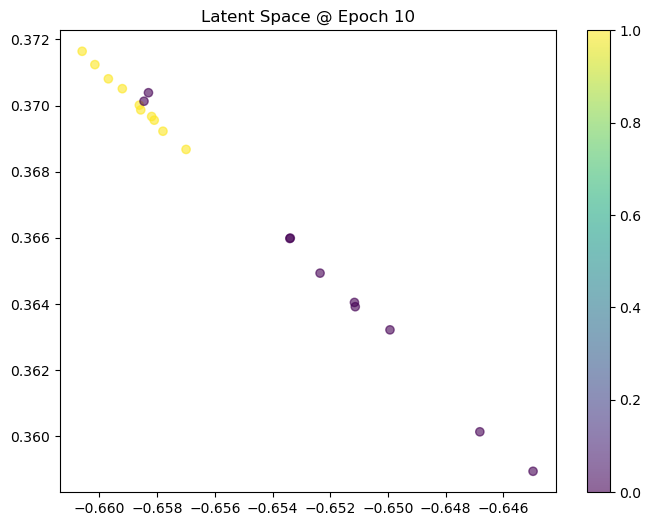

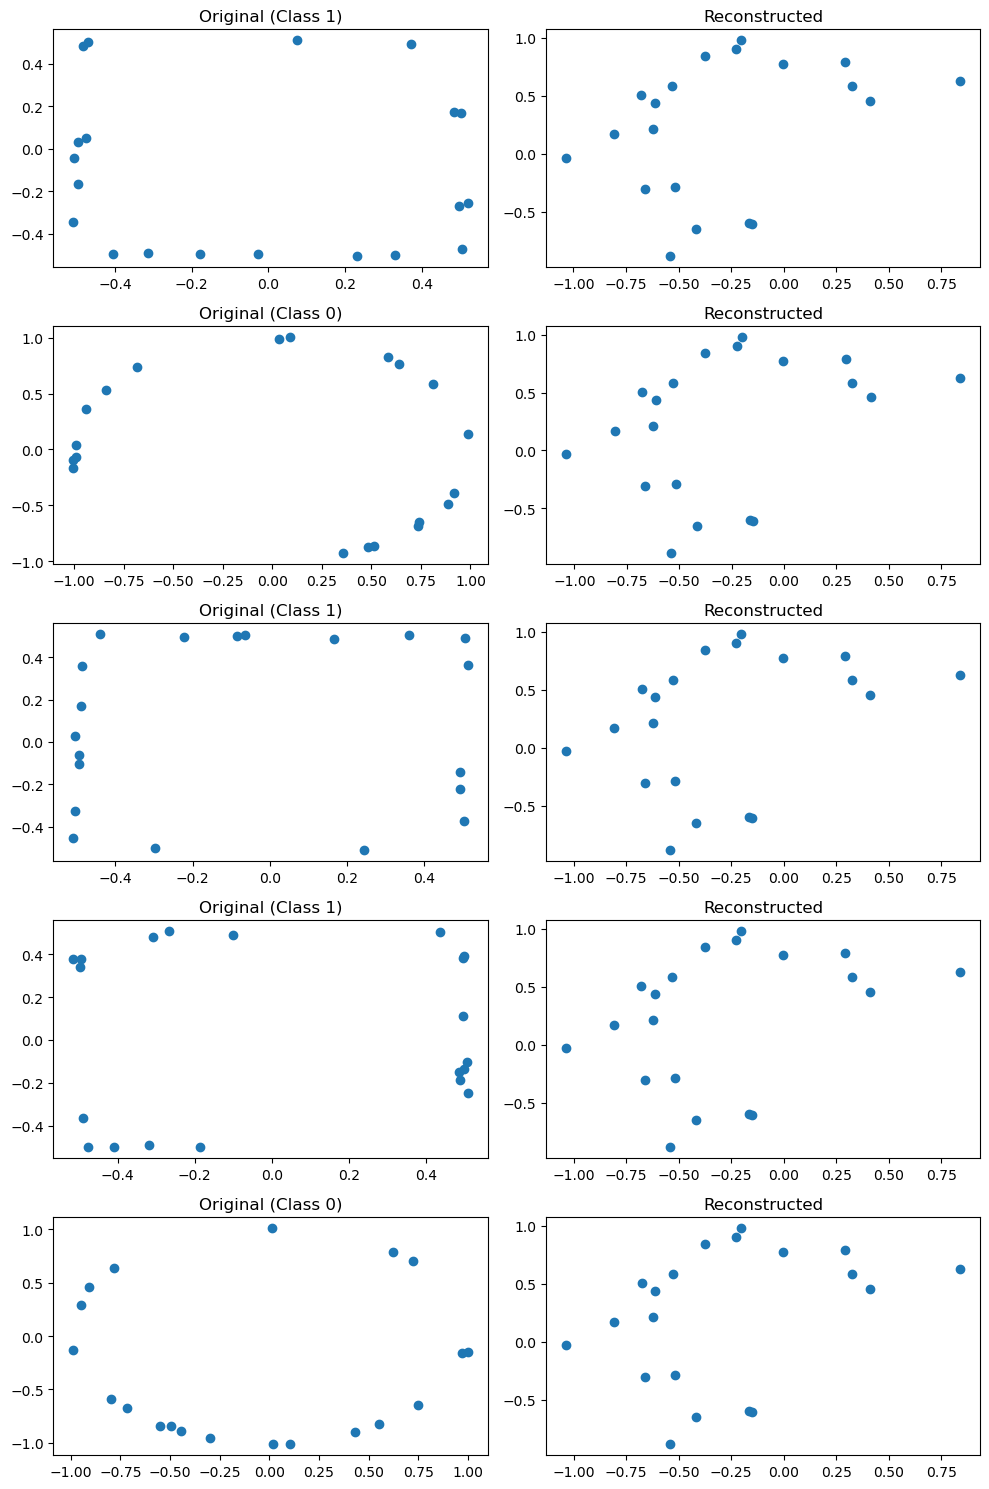

Epoch 010 | Loss: 2.8884 (Recon: 1.0975 Class: 0.6934)
Epoch 011 | Loss: 3.2326 (Recon: 1.2679 Class: 0.6968)
Epoch 012 | Loss: 2.8002 (Recon: 1.0516 Class: 0.6969)
Epoch 013 | Loss: 2.6862 (Recon: 0.9959 Class: 0.6944)
Epoch 014 | Loss: 2.6570 (Recon: 0.9811 Class: 0.6947)
Epoch 015 | Loss: 2.6335 (Recon: 0.9697 Class: 0.6941)
Epoch 016 | Loss: 2.5984 (Recon: 0.9523 Class: 0.6937)
Epoch 017 | Loss: 2.5738 (Recon: 0.9406 Class: 0.6926)
Epoch 018 | Loss: 2.5541 (Recon: 0.9322 Class: 0.6897)
Epoch 019 | Loss: 2.4186 (Recon: 0.9197 Class: 0.5793)


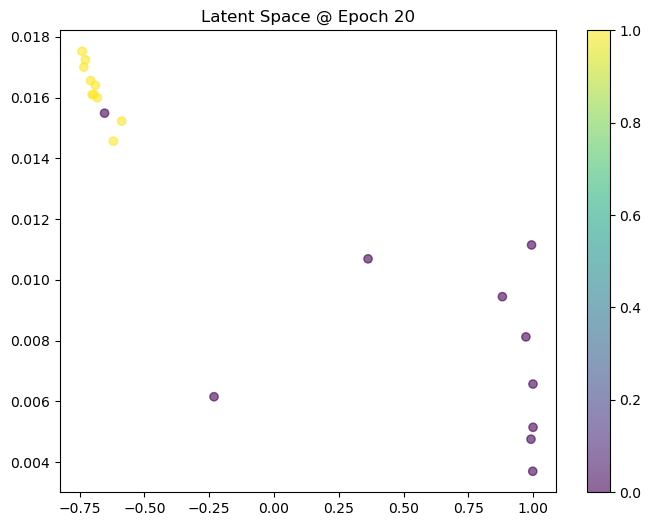

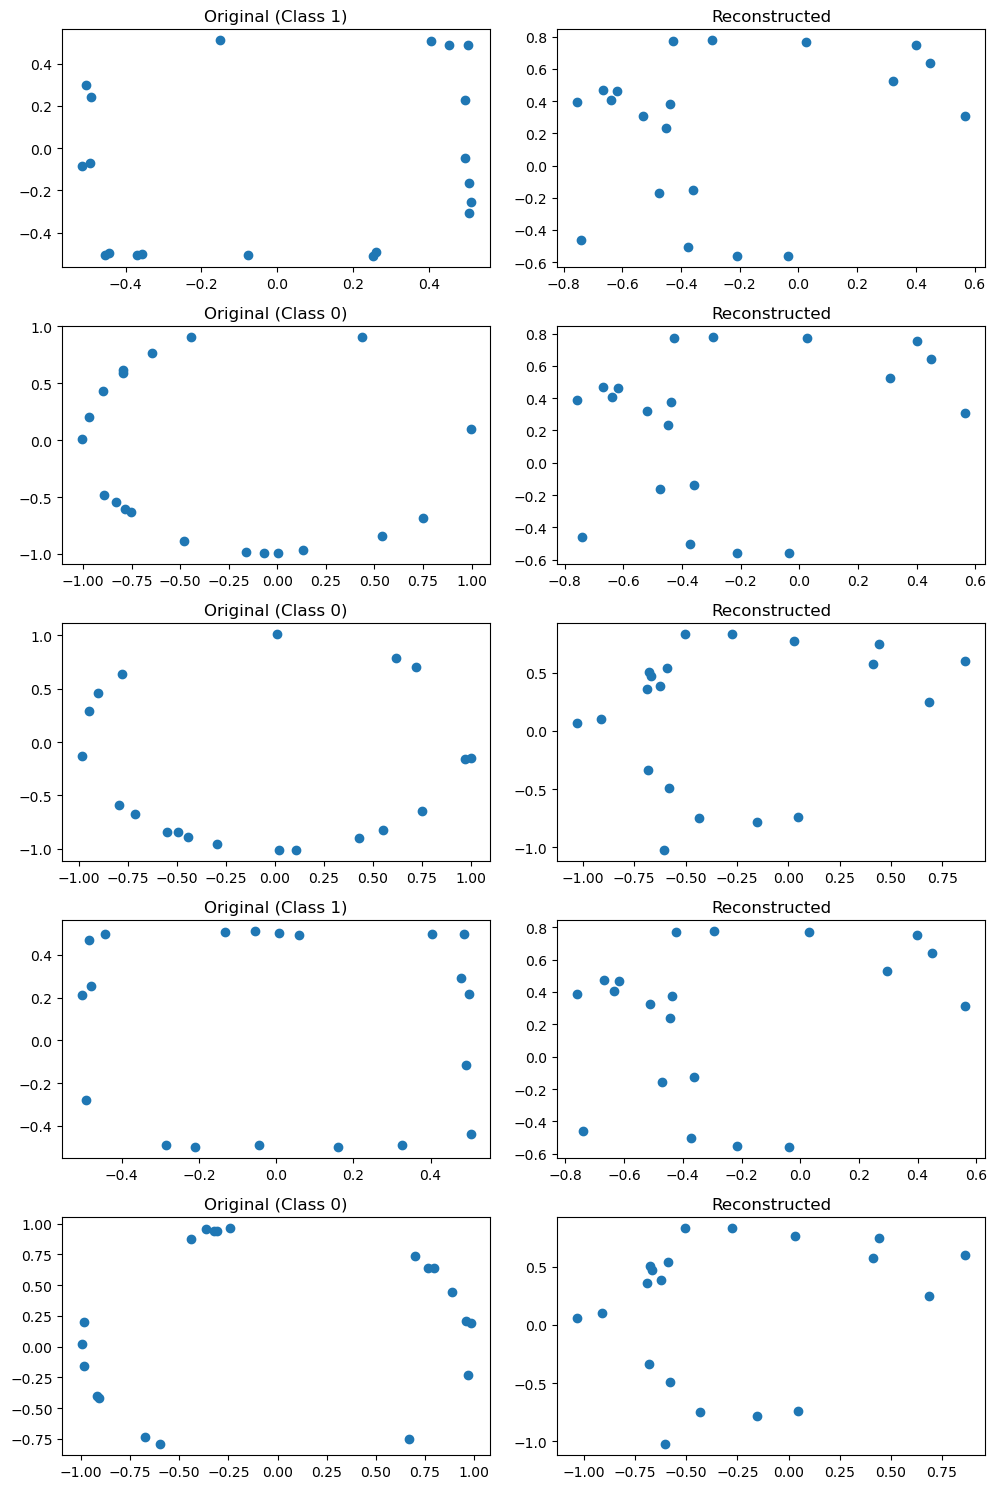

Epoch 020 | Loss: 2.1354 (Recon: 0.8405 Class: 0.4544)
Epoch 021 | Loss: 1.9591 (Recon: 0.7936 Class: 0.3718)
Epoch 022 | Loss: 1.7358 (Recon: 0.7444 Class: 0.2470)
Epoch 023 | Loss: 1.6206 (Recon: 0.7053 Class: 0.2100)
Epoch 024 | Loss: 1.4837 (Recon: 0.6624 Class: 0.1590)
Epoch 025 | Loss: 1.4587 (Recon: 0.6347 Class: 0.1892)
Epoch 026 | Loss: 1.3371 (Recon: 0.6096 Class: 0.1178)
Epoch 027 | Loss: 1.2586 (Recon: 0.5754 Class: 0.1078)
Epoch 028 | Loss: 1.2033 (Recon: 0.5555 Class: 0.0923)
Epoch 029 | Loss: 1.1304 (Recon: 0.5349 Class: 0.0605)


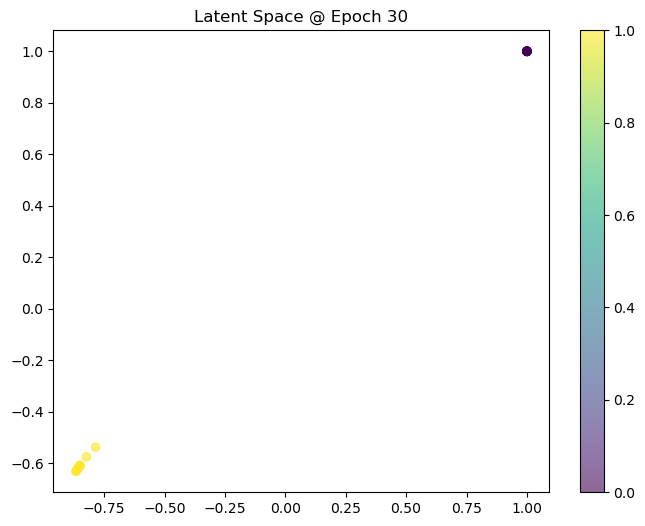

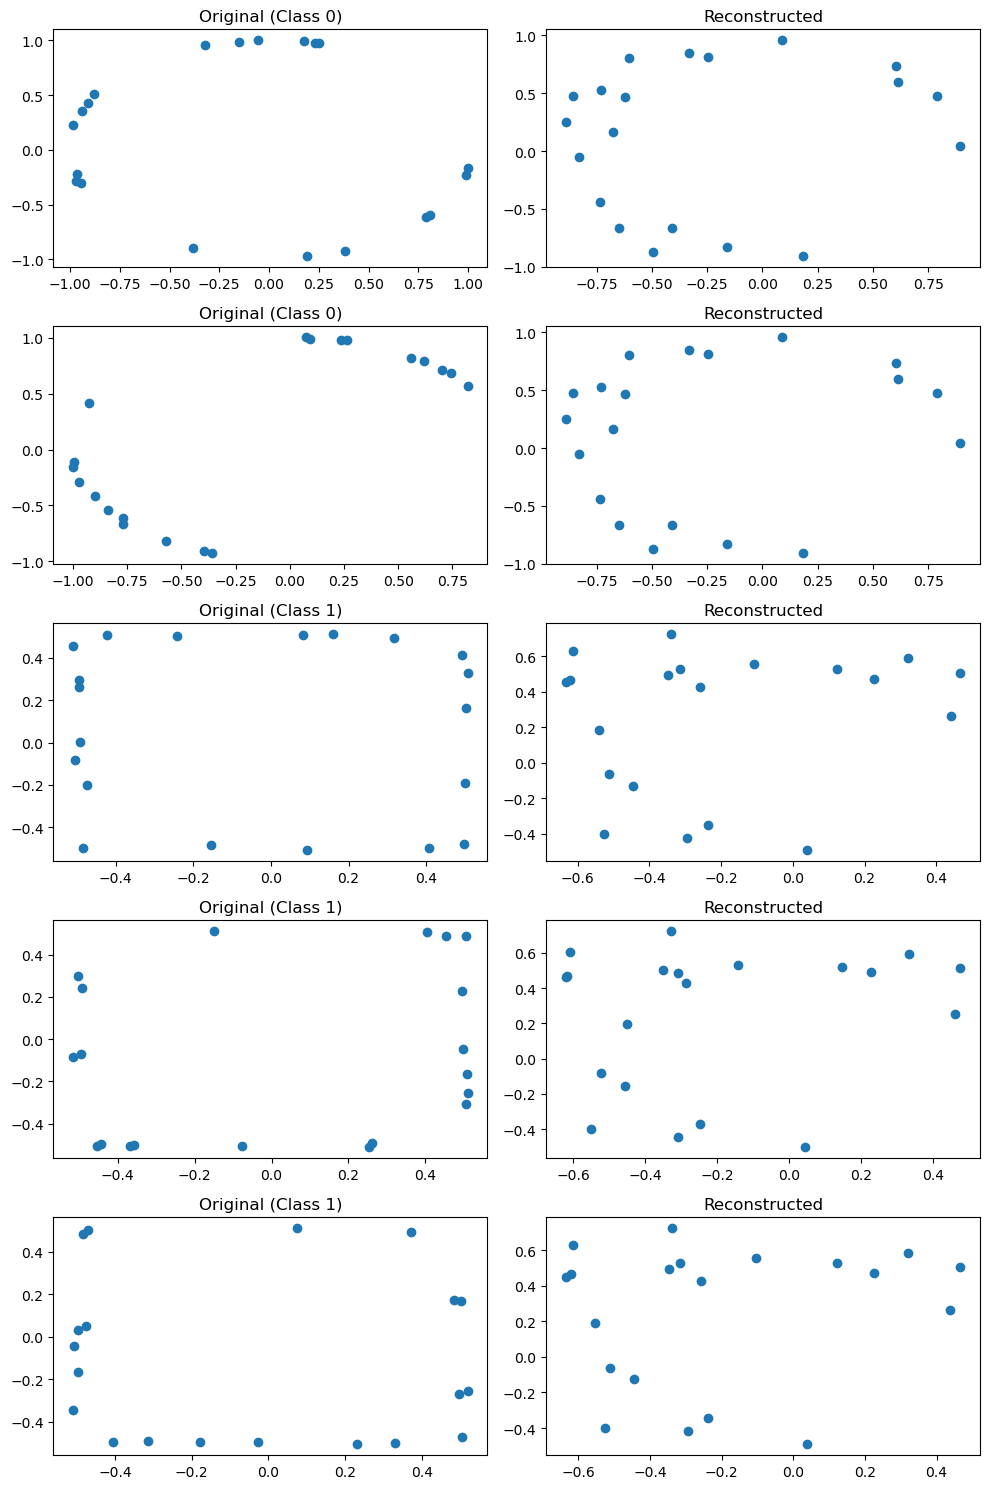

Epoch 030 | Loss: 1.0693 (Recon: 0.5139 Class: 0.0415)
Epoch 031 | Loss: 1.0709 (Recon: 0.5184 Class: 0.0341)
Epoch 032 | Loss: 1.0393 (Recon: 0.5049 Class: 0.0295)
Epoch 033 | Loss: 1.1612 (Recon: 0.5676 Class: 0.0259)
Epoch 034 | Loss: 1.0897 (Recon: 0.5332 Class: 0.0234)
Epoch 035 | Loss: 1.0351 (Recon: 0.5069 Class: 0.0214)
Epoch 036 | Loss: 1.0231 (Recon: 0.5021 Class: 0.0189)
Epoch 037 | Loss: 0.9451 (Recon: 0.4640 Class: 0.0171)
Epoch 038 | Loss: 0.9408 (Recon: 0.4627 Class: 0.0155)
Epoch 039 | Loss: 0.9770 (Recon: 0.4816 Class: 0.0138)


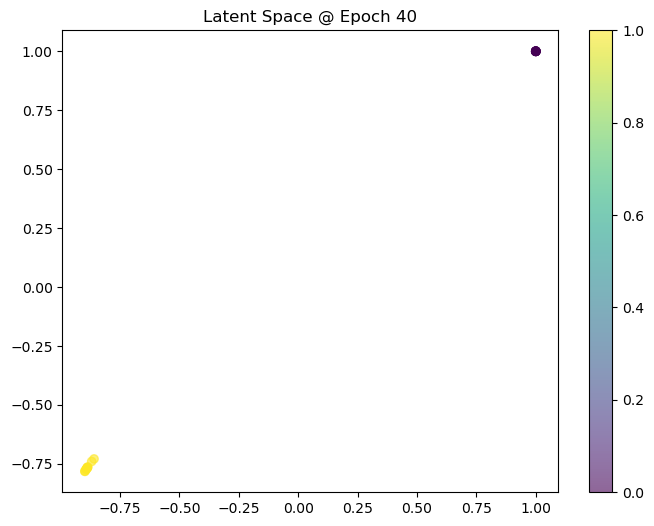

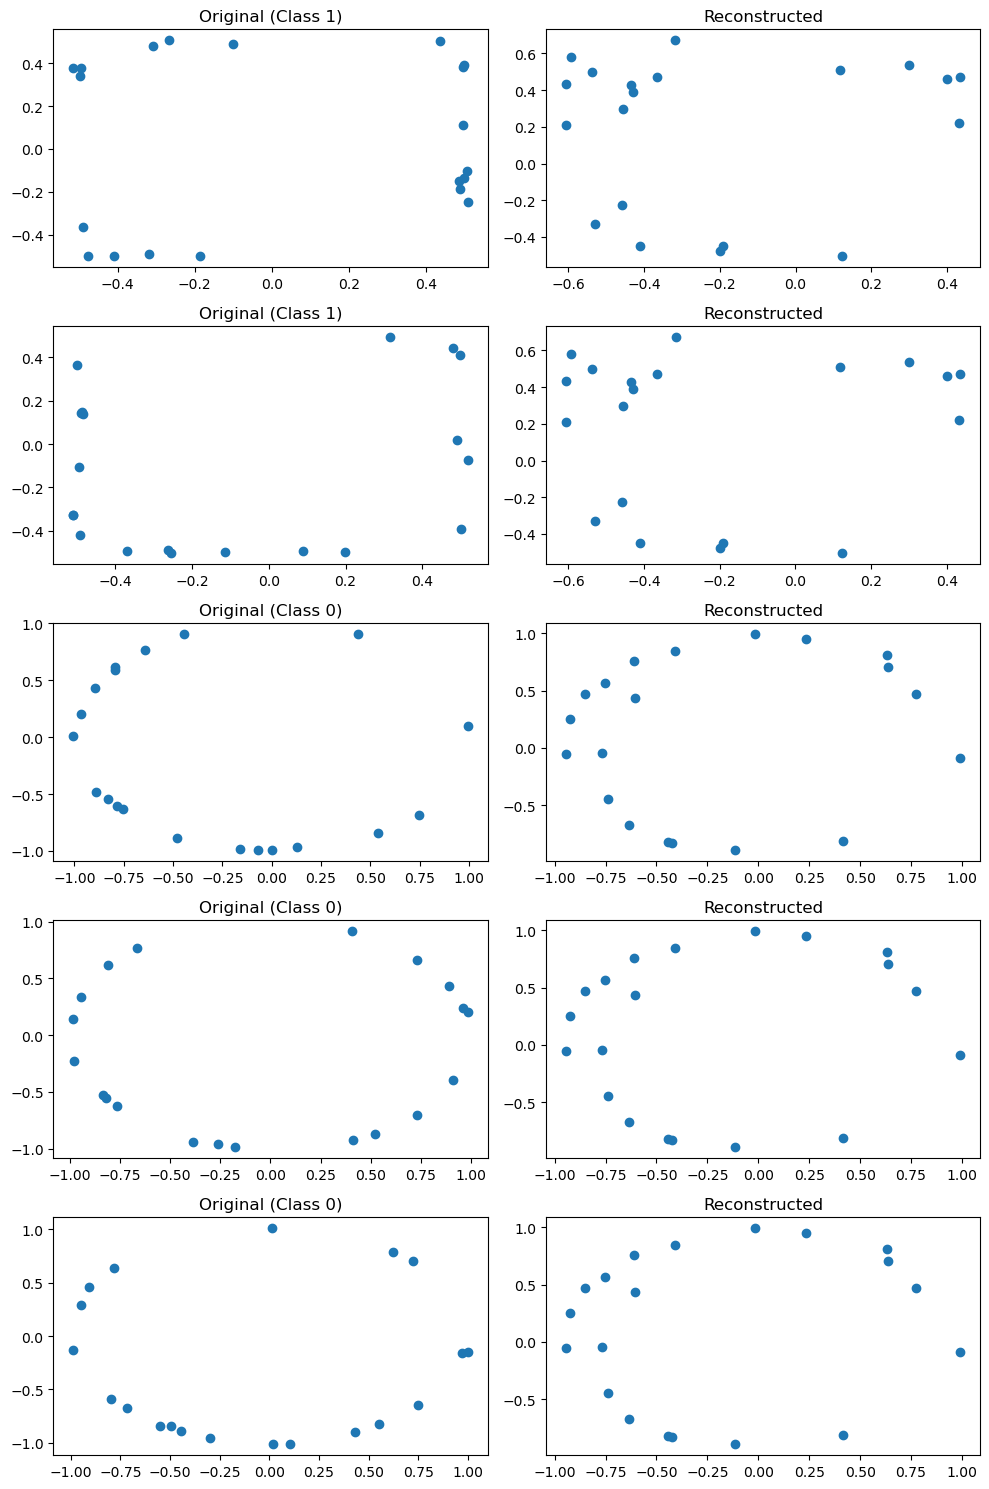

Epoch 040 | Loss: 0.9441 (Recon: 0.4658 Class: 0.0125)
Epoch 041 | Loss: 0.9032 (Recon: 0.4459 Class: 0.0115)
Epoch 042 | Loss: 0.8743 (Recon: 0.4319 Class: 0.0105)
Epoch 043 | Loss: 0.8510 (Recon: 0.4207 Class: 0.0096)
Epoch 044 | Loss: 0.8387 (Recon: 0.4149 Class: 0.0089)
Epoch 045 | Loss: 0.8478 (Recon: 0.4199 Class: 0.0080)
Epoch 046 | Loss: 0.8423 (Recon: 0.4174 Class: 0.0075)
Epoch 047 | Loss: 0.8188 (Recon: 0.4059 Class: 0.0070)
Epoch 048 | Loss: 0.8344 (Recon: 0.4140 Class: 0.0064)
Epoch 049 | Loss: 0.8295 (Recon: 0.4118 Class: 0.0060)


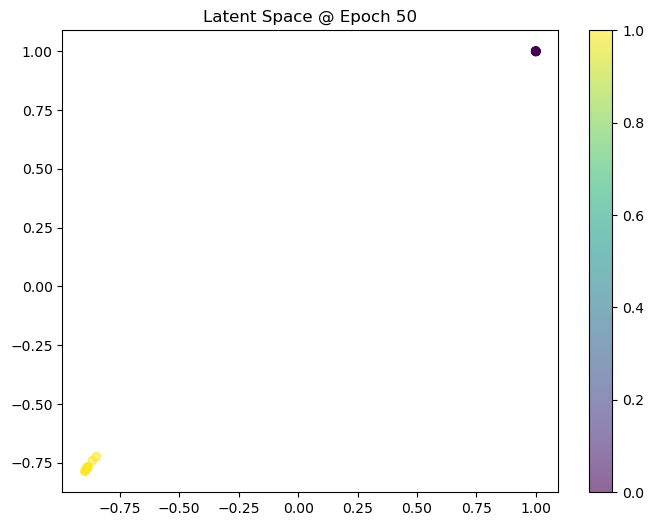

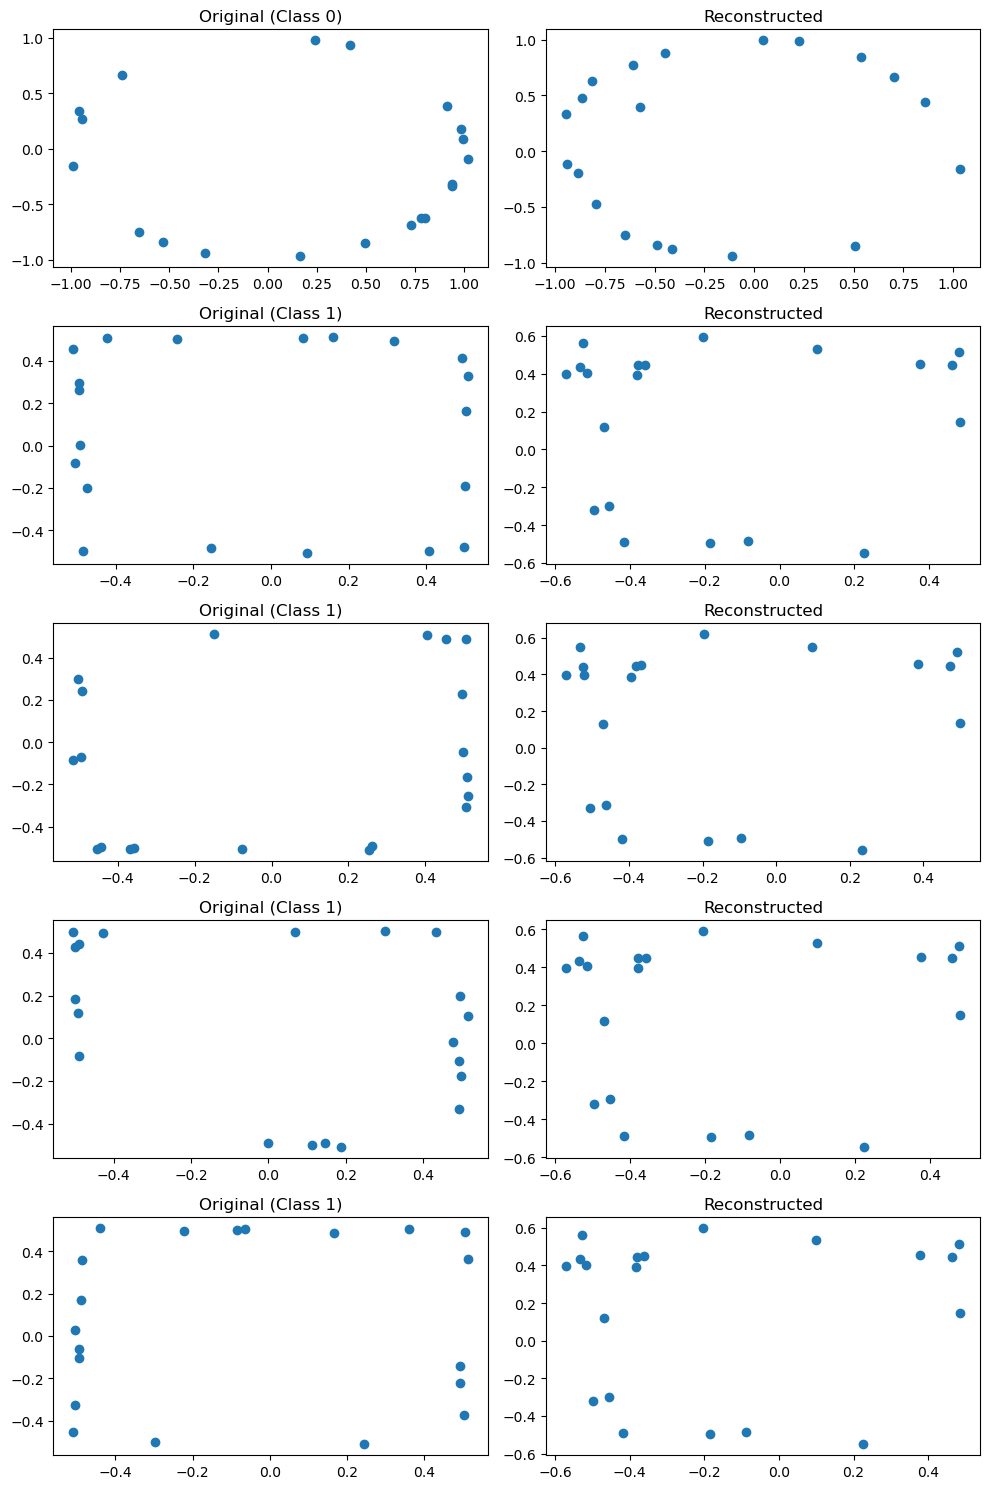

Epoch 050 | Loss: 0.8102 (Recon: 0.4024 Class: 0.0055)
Epoch 051 | Loss: 0.8142 (Recon: 0.4045 Class: 0.0051)
Epoch 052 | Loss: 0.8128 (Recon: 0.4040 Class: 0.0048)
Epoch 053 | Loss: 0.8114 (Recon: 0.4035 Class: 0.0045)
Epoch 054 | Loss: 0.7937 (Recon: 0.3947 Class: 0.0042)
Epoch 055 | Loss: 0.8097 (Recon: 0.4029 Class: 0.0039)
Epoch 056 | Loss: 0.7857 (Recon: 0.3910 Class: 0.0037)
Epoch 057 | Loss: 0.8013 (Recon: 0.3989 Class: 0.0035)
Epoch 058 | Loss: 0.7856 (Recon: 0.3911 Class: 0.0033)
Epoch 059 | Loss: 0.7790 (Recon: 0.3880 Class: 0.0031)


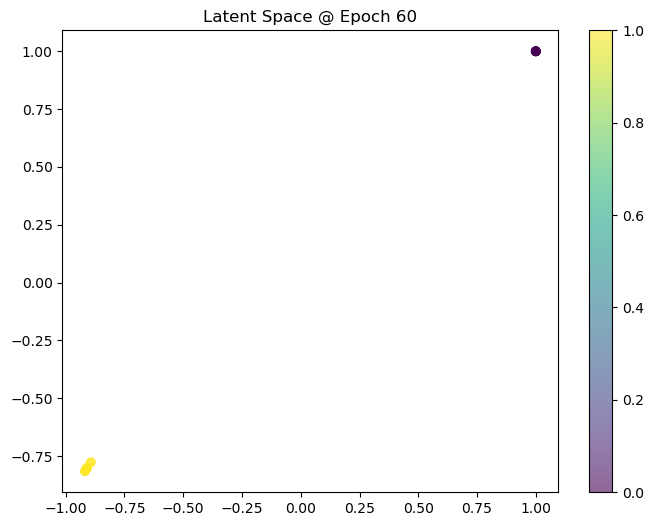

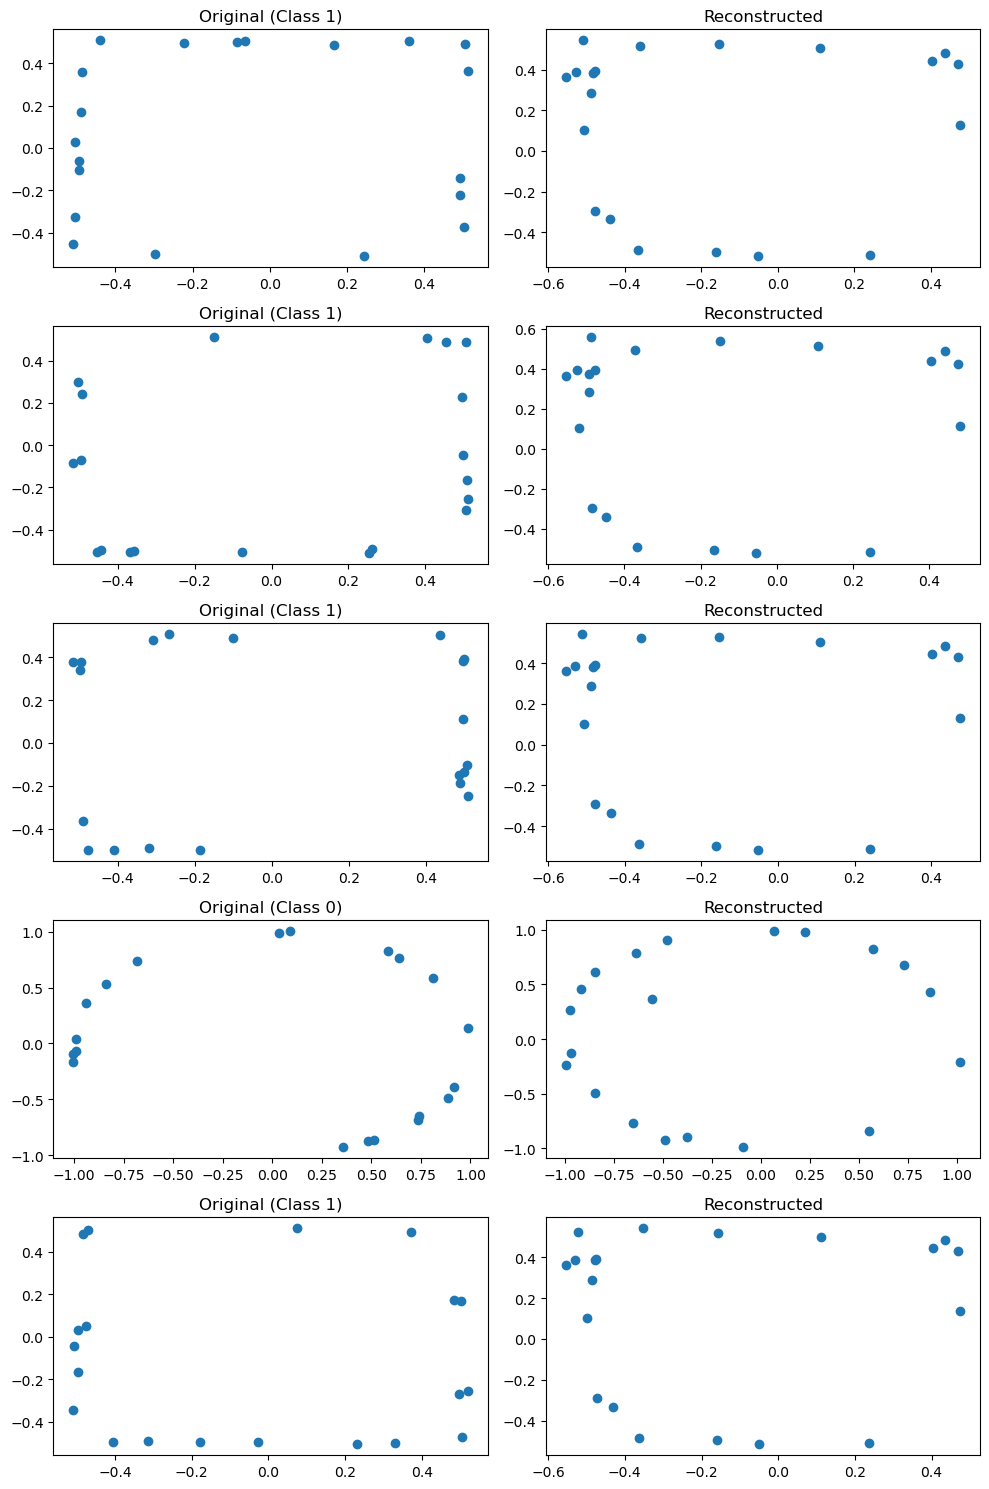

Epoch 060 | Loss: 0.7743 (Recon: 0.3857 Class: 0.0029)
Epoch 061 | Loss: 0.7649 (Recon: 0.3810 Class: 0.0028)
Epoch 062 | Loss: 0.7856 (Recon: 0.3915 Class: 0.0026)
Epoch 063 | Loss: 0.7754 (Recon: 0.3865 Class: 0.0025)
Epoch 064 | Loss: 0.7777 (Recon: 0.3877 Class: 0.0024)
Epoch 065 | Loss: 0.7779 (Recon: 0.3878 Class: 0.0022)
Epoch 066 | Loss: 0.7637 (Recon: 0.3808 Class: 0.0021)
Epoch 067 | Loss: 0.7541 (Recon: 0.3760 Class: 0.0020)
Epoch 068 | Loss: 0.7601 (Recon: 0.3791 Class: 0.0020)
Epoch 069 | Loss: 0.7597 (Recon: 0.3789 Class: 0.0019)


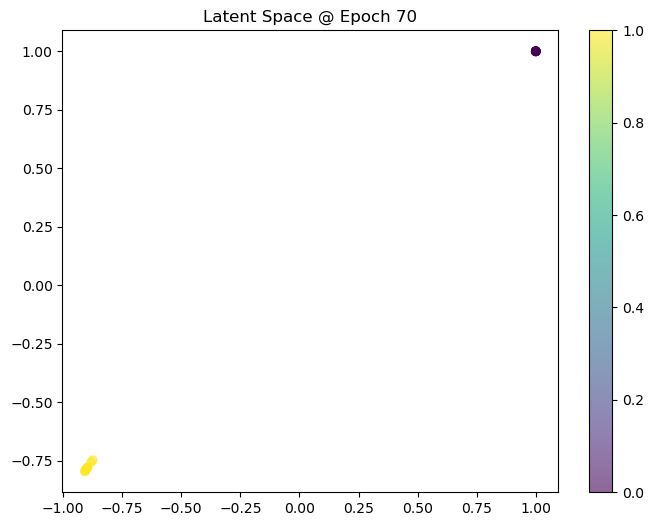

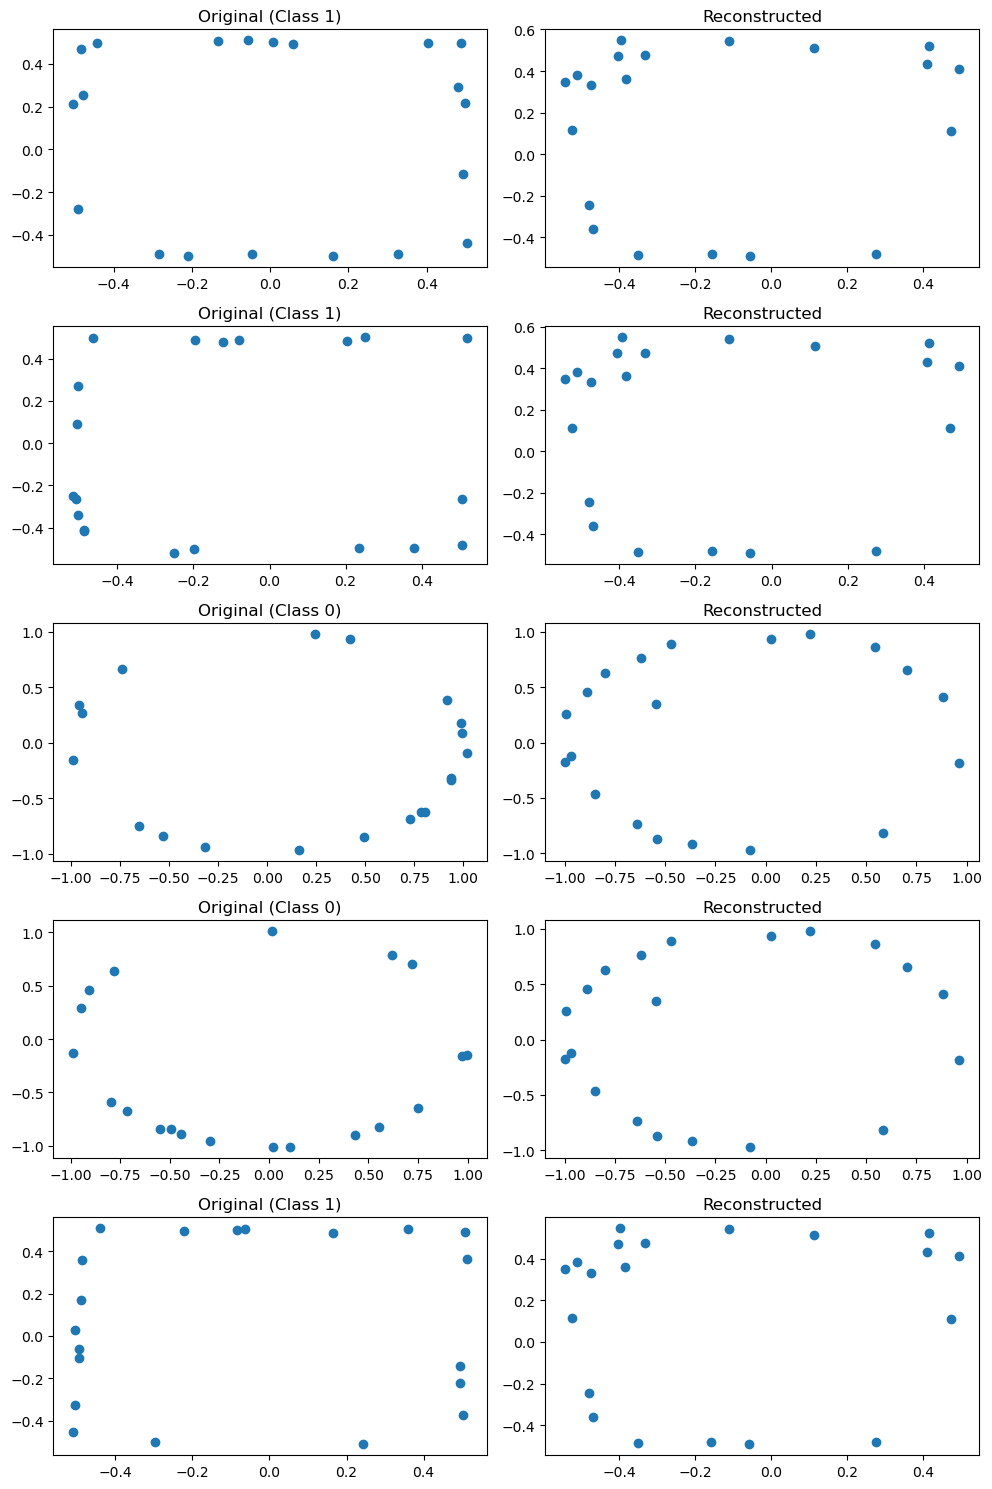

Epoch 070 | Loss: 0.7463 (Recon: 0.3723 Class: 0.0018)
Epoch 071 | Loss: 0.7638 (Recon: 0.3810 Class: 0.0017)
Epoch 072 | Loss: 0.7582 (Recon: 0.3783 Class: 0.0016)
Epoch 073 | Loss: 0.7755 (Recon: 0.3870 Class: 0.0016)
Epoch 074 | Loss: 0.7511 (Recon: 0.3748 Class: 0.0015)
Epoch 075 | Loss: 0.7397 (Recon: 0.3691 Class: 0.0015)
Epoch 076 | Loss: 0.7430 (Recon: 0.3708 Class: 0.0014)
Epoch 077 | Loss: 0.7440 (Recon: 0.3713 Class: 0.0014)
Epoch 078 | Loss: 0.7378 (Recon: 0.3683 Class: 0.0013)
Epoch 079 | Loss: 0.7322 (Recon: 0.3655 Class: 0.0013)


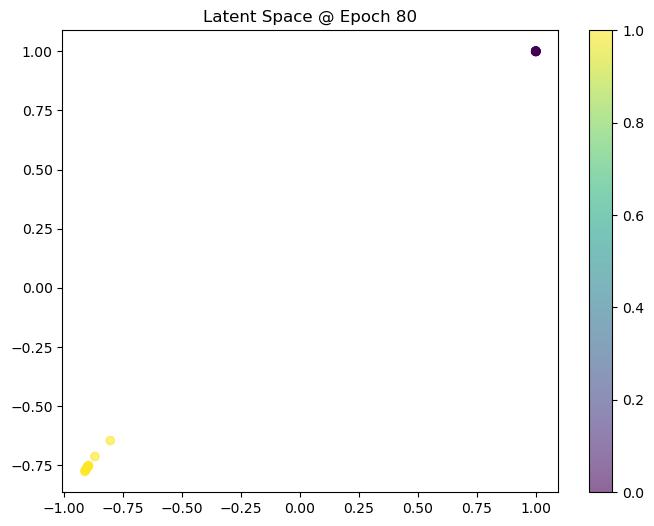

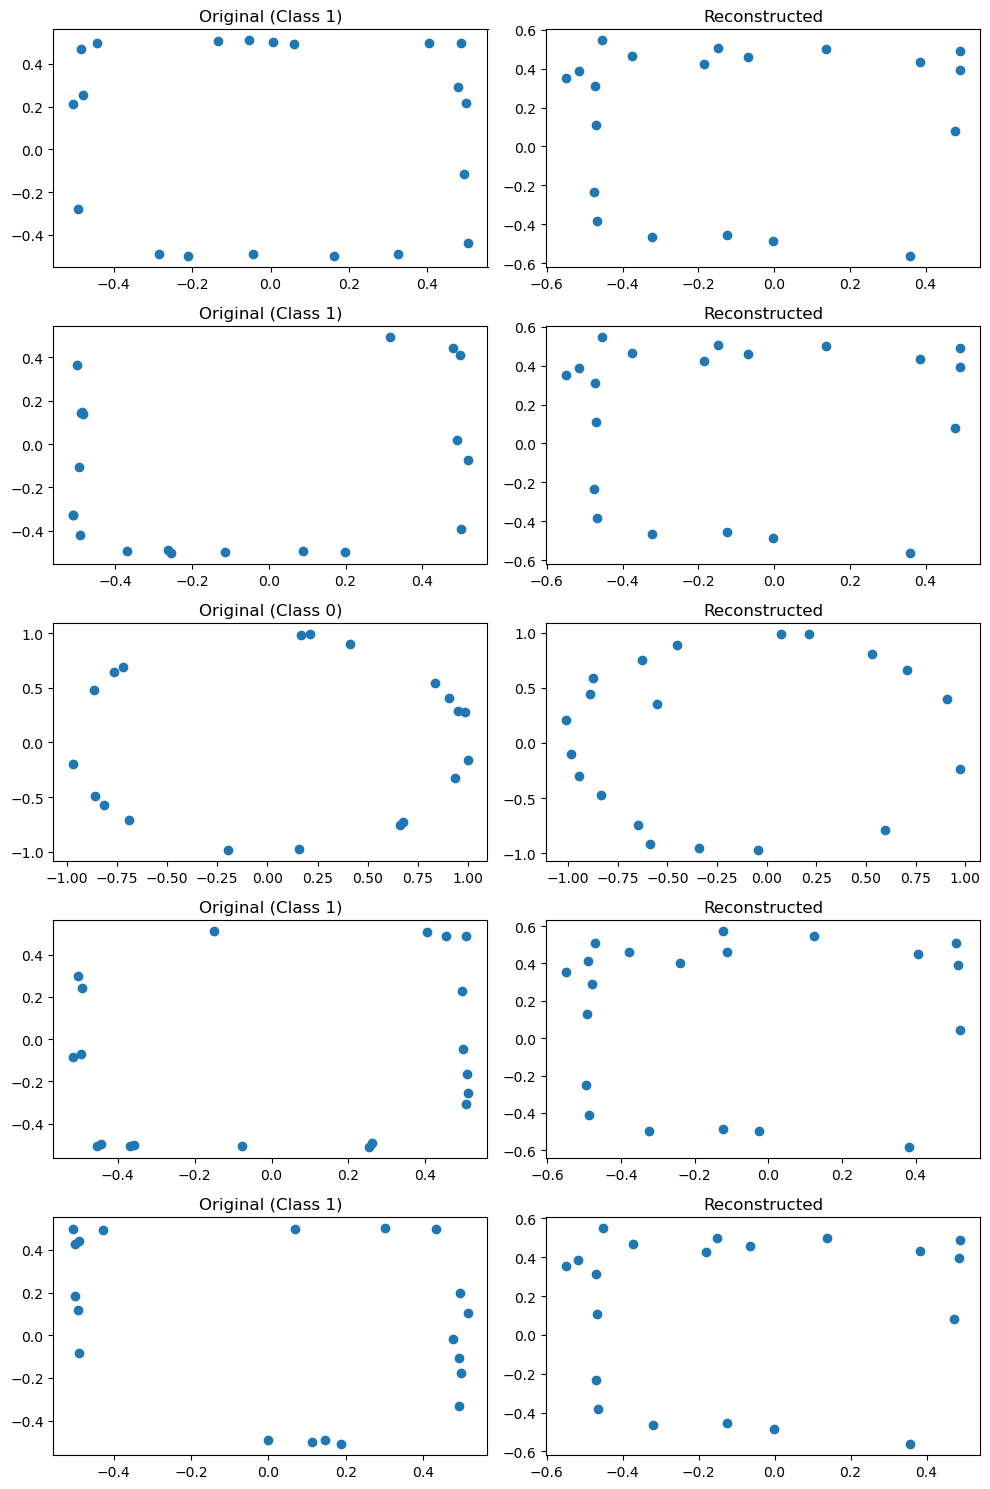

Epoch 080 | Loss: 0.7371 (Recon: 0.3680 Class: 0.0012)
Epoch 081 | Loss: 0.7379 (Recon: 0.3684 Class: 0.0012)
Epoch 082 | Loss: 0.7252 (Recon: 0.3620 Class: 0.0011)
Epoch 083 | Loss: 0.7262 (Recon: 0.3626 Class: 0.0011)
Epoch 084 | Loss: 0.7302 (Recon: 0.3646 Class: 0.0011)
Epoch 085 | Loss: 0.7180 (Recon: 0.3585 Class: 0.0010)
Epoch 086 | Loss: 0.7221 (Recon: 0.3605 Class: 0.0010)
Epoch 087 | Loss: 0.7658 (Recon: 0.3824 Class: 0.0010)
Epoch 088 | Loss: 0.7910 (Recon: 0.3951 Class: 0.0009)
Epoch 089 | Loss: 0.7741 (Recon: 0.3866 Class: 0.0009)


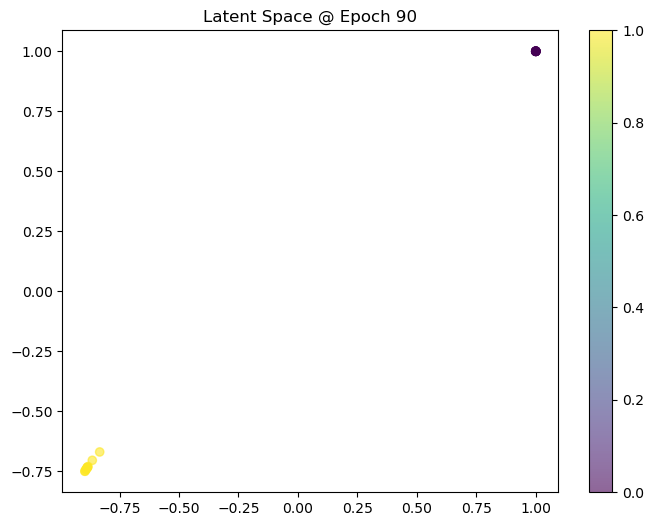

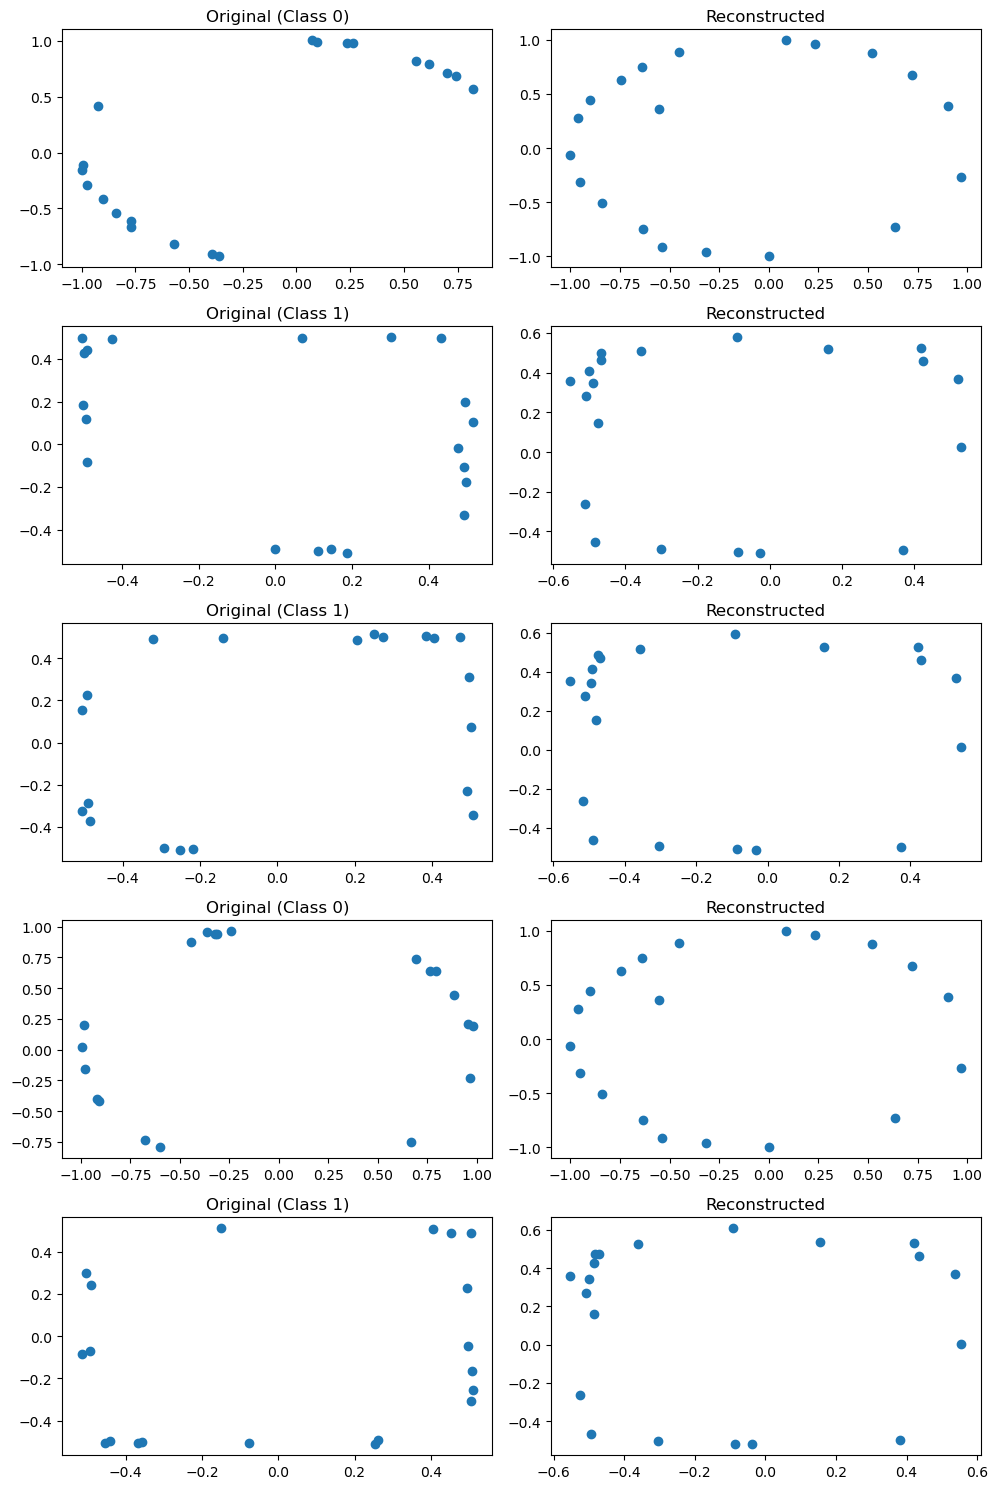

Epoch 090 | Loss: 0.7514 (Recon: 0.3752 Class: 0.0009)
Epoch 091 | Loss: 0.7309 (Recon: 0.3650 Class: 0.0008)
Epoch 092 | Loss: 0.7245 (Recon: 0.3618 Class: 0.0008)
Epoch 093 | Loss: 0.7507 (Recon: 0.3750 Class: 0.0008)
Epoch 094 | Loss: 0.7369 (Recon: 0.3681 Class: 0.0008)
Epoch 095 | Loss: 0.7335 (Recon: 0.3664 Class: 0.0008)
Epoch 096 | Loss: 0.7144 (Recon: 0.3568 Class: 0.0007)
Epoch 097 | Loss: 0.7409 (Recon: 0.3701 Class: 0.0007)
Epoch 098 | Loss: 0.7457 (Recon: 0.3725 Class: 0.0007)
Epoch 099 | Loss: 0.7437 (Recon: 0.3715 Class: 0.0007)


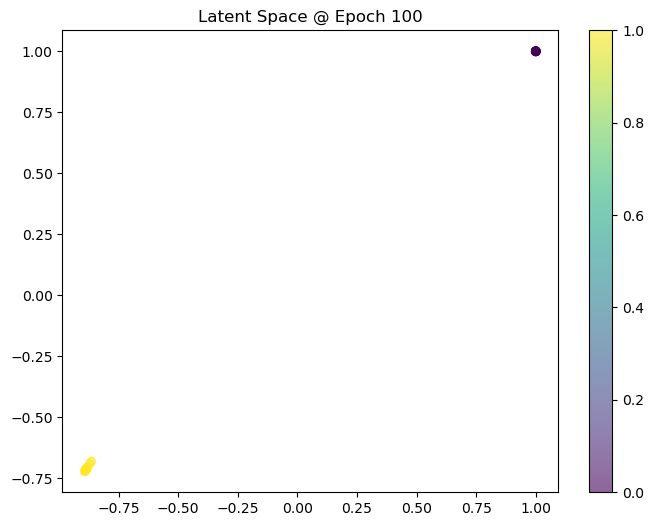

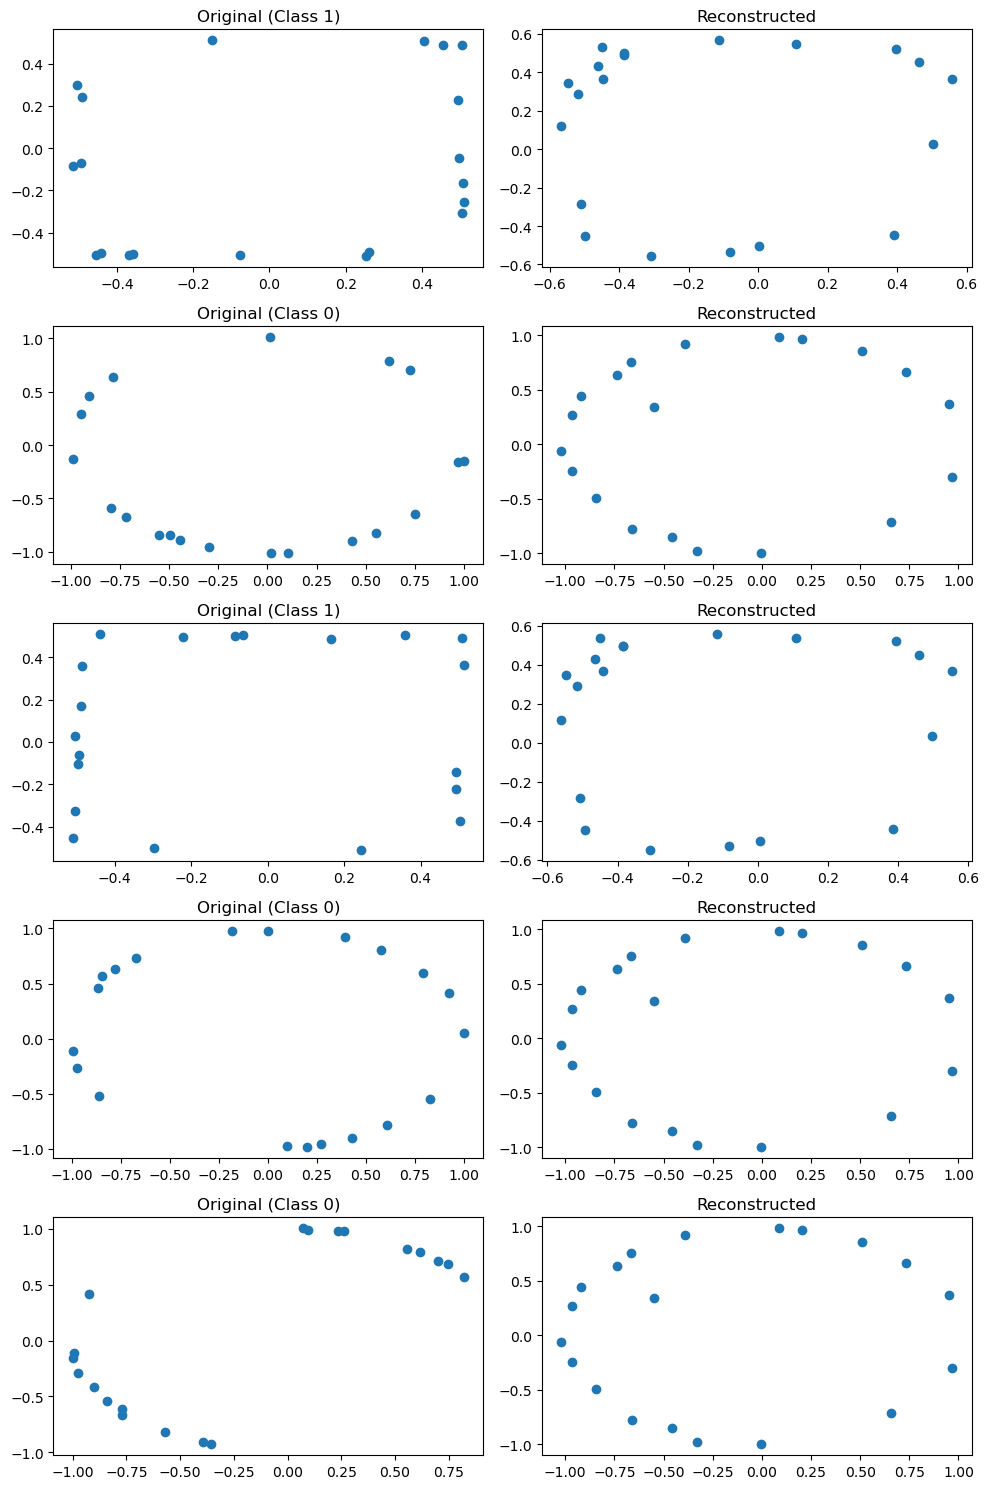

Epoch 100 | Loss: 0.7386 (Recon: 0.3690 Class: 0.0007)
Epoch 101 | Loss: 0.7445 (Recon: 0.3719 Class: 0.0006)
Epoch 102 | Loss: 0.7456 (Recon: 0.3725 Class: 0.0006)
Epoch 103 | Loss: 0.7363 (Recon: 0.3678 Class: 0.0006)
Epoch 104 | Loss: 0.7405 (Recon: 0.3699 Class: 0.0006)
Epoch 105 | Loss: 0.7371 (Recon: 0.3682 Class: 0.0006)
Epoch 106 | Loss: 0.7370 (Recon: 0.3682 Class: 0.0006)
Epoch 107 | Loss: 0.7349 (Recon: 0.3672 Class: 0.0006)
Epoch 108 | Loss: 0.7662 (Recon: 0.3828 Class: 0.0006)
Epoch 109 | Loss: 0.7434 (Recon: 0.3715 Class: 0.0005)


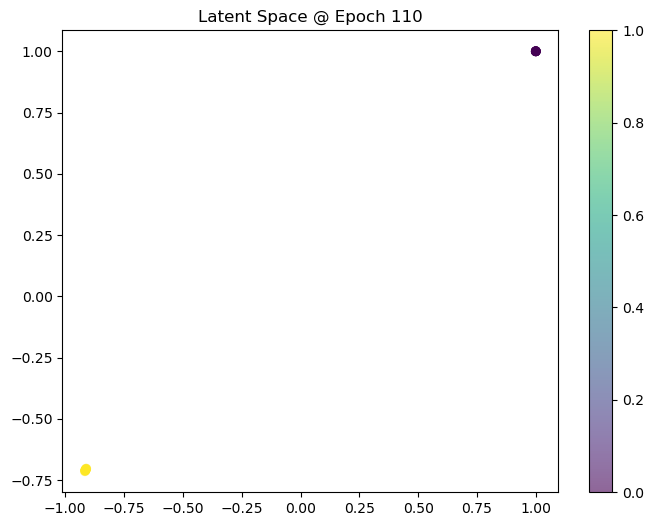

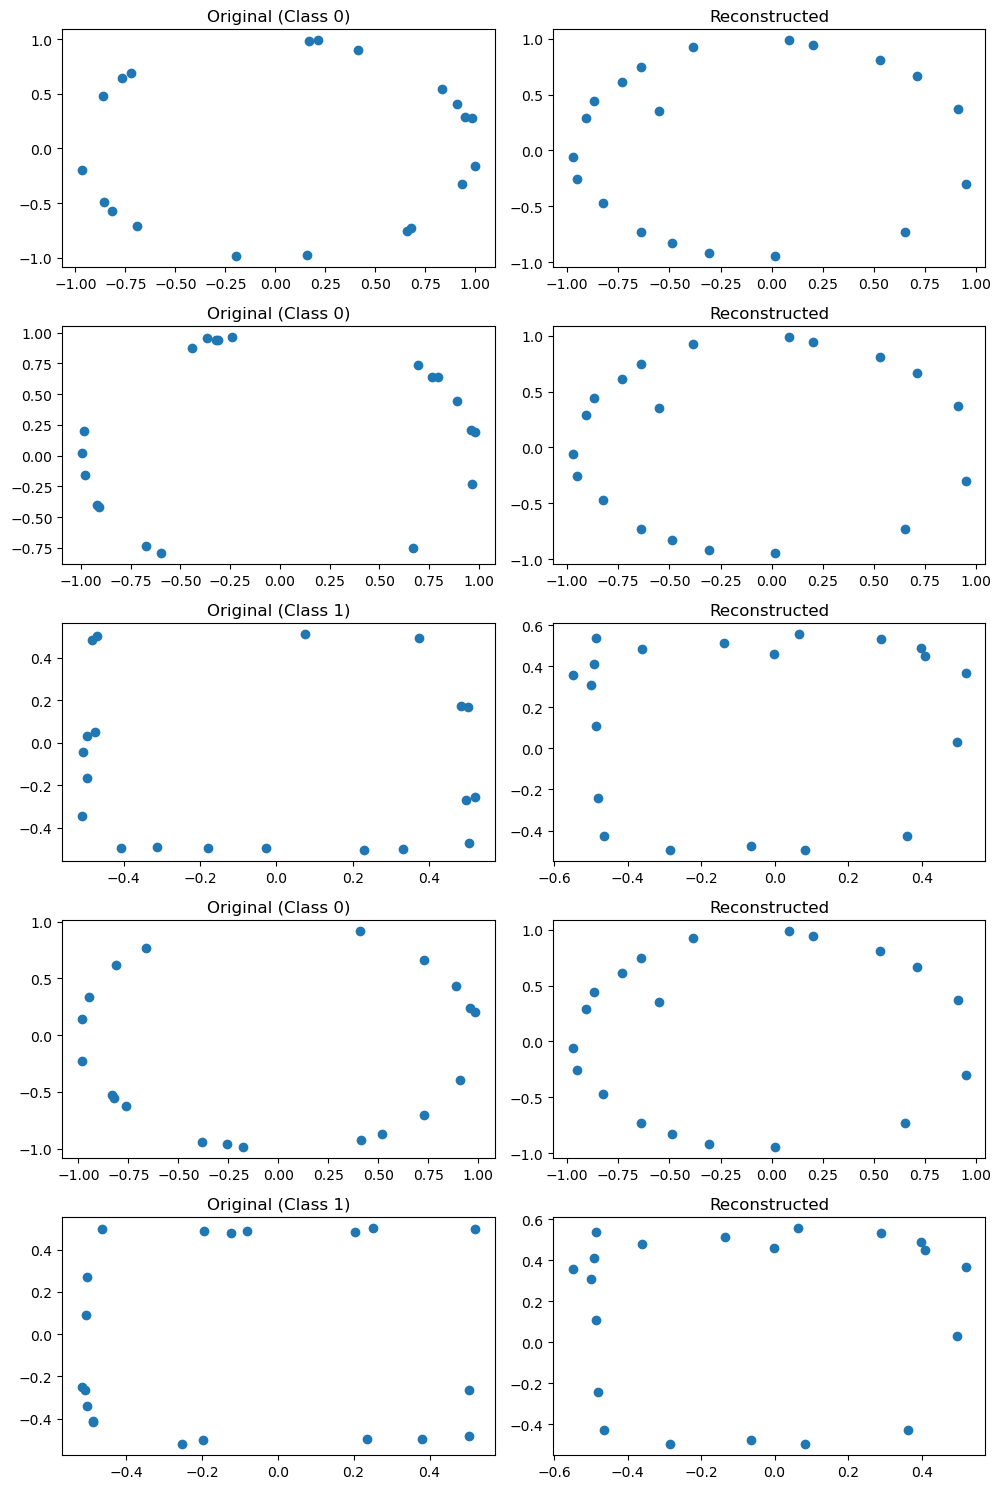

Epoch 110 | Loss: 0.7286 (Recon: 0.3636 Class: 0.0014)
Epoch 111 | Loss: 0.7387 (Recon: 0.3691 Class: 0.0006)
Epoch 112 | Loss: 0.7246 (Recon: 0.3621 Class: 0.0005)
Epoch 113 | Loss: 0.7141 (Recon: 0.3568 Class: 0.0005)
Epoch 114 | Loss: 0.7384 (Recon: 0.3690 Class: 0.0005)
Epoch 115 | Loss: 0.7374 (Recon: 0.3685 Class: 0.0005)
Epoch 116 | Loss: 0.7495 (Recon: 0.3696 Class: 0.0104)
Epoch 117 | Loss: 0.7423 (Recon: 0.3709 Class: 0.0005)
Epoch 118 | Loss: 0.7106 (Recon: 0.3551 Class: 0.0004)
Epoch 119 | Loss: 0.7245 (Recon: 0.3620 Class: 0.0004)


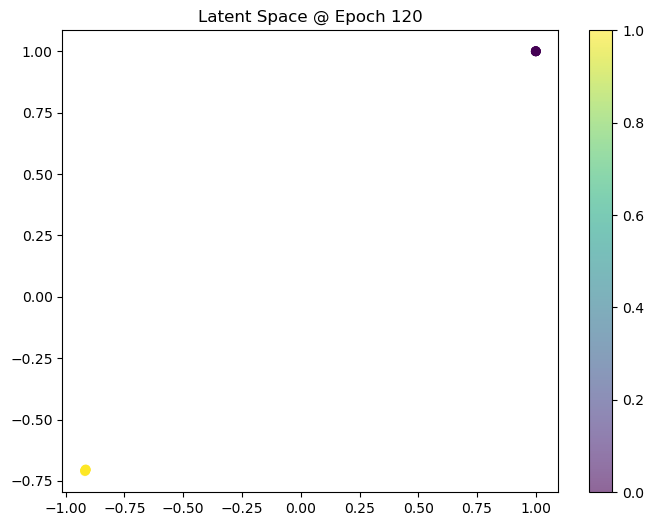

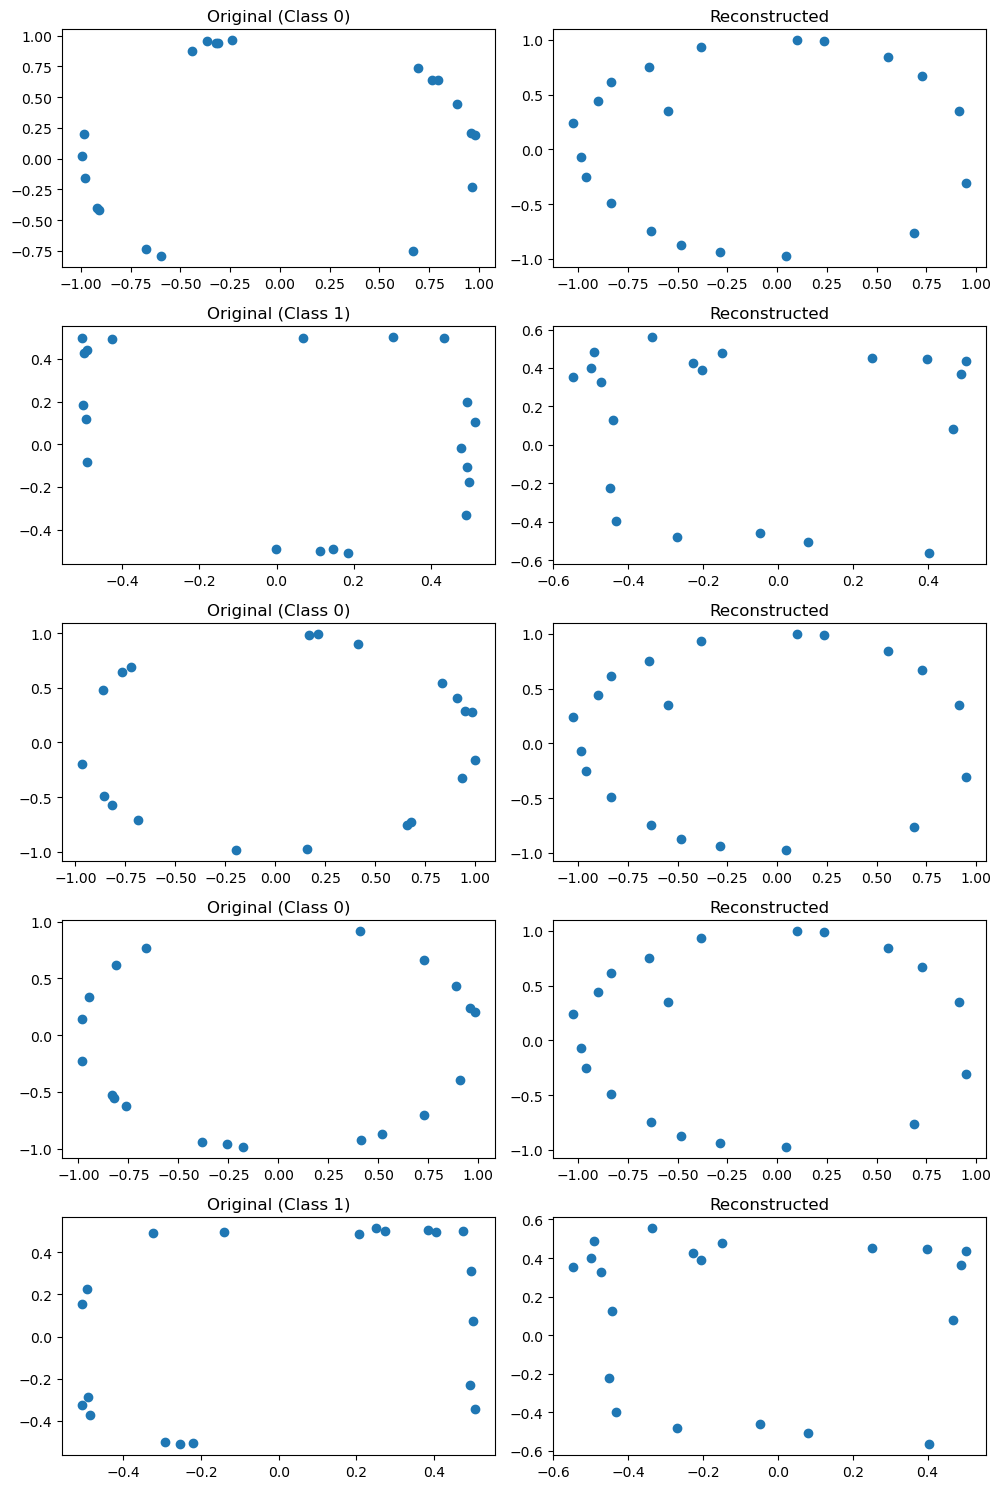

Epoch 120 | Loss: 0.7281 (Recon: 0.3638 Class: 0.0004)
Epoch 121 | Loss: 0.7264 (Recon: 0.3630 Class: 0.0004)
Epoch 122 | Loss: 0.7121 (Recon: 0.3558 Class: 0.0004)
Epoch 123 | Loss: 0.7172 (Recon: 0.3584 Class: 0.0004)
Epoch 124 | Loss: 0.7316 (Recon: 0.3656 Class: 0.0004)
Epoch 125 | Loss: 0.7068 (Recon: 0.3532 Class: 0.0004)
Epoch 126 | Loss: 0.7039 (Recon: 0.3518 Class: 0.0004)
Epoch 127 | Loss: 0.7210 (Recon: 0.3603 Class: 0.0004)
Epoch 128 | Loss: 0.7316 (Recon: 0.3656 Class: 0.0004)
Epoch 129 | Loss: 0.7279 (Recon: 0.3638 Class: 0.0003)


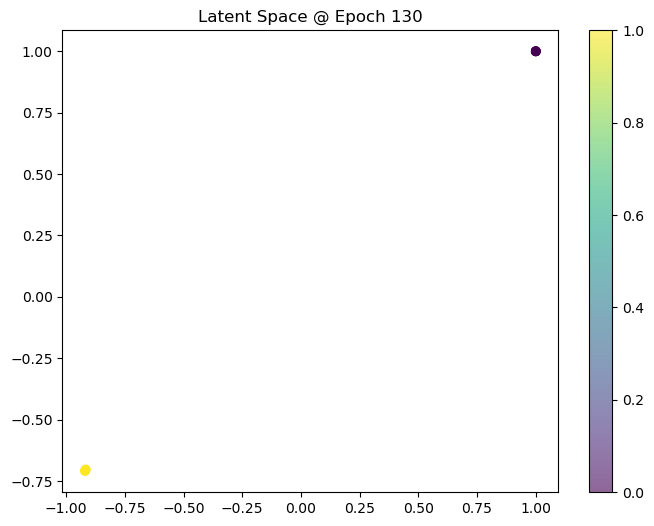

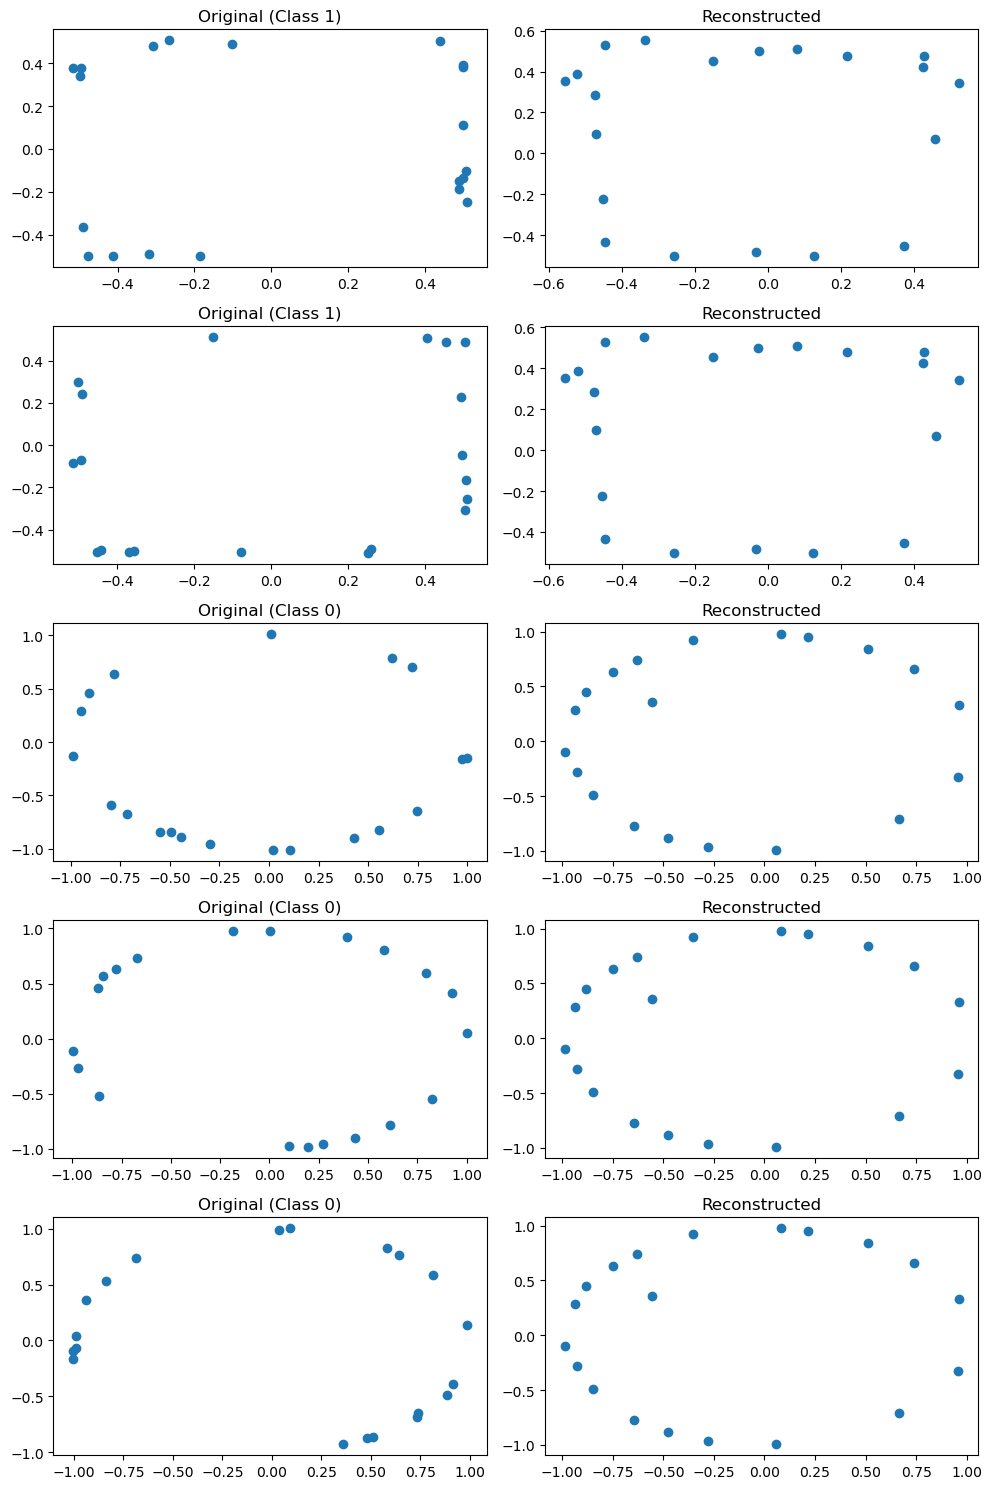

Epoch 130 | Loss: 0.7210 (Recon: 0.3603 Class: 0.0003)
Epoch 131 | Loss: 0.7163 (Recon: 0.3580 Class: 0.0003)
Epoch 132 | Loss: 0.7011 (Recon: 0.3504 Class: 0.0003)
Epoch 133 | Loss: 0.7091 (Recon: 0.3544 Class: 0.0003)
Epoch 134 | Loss: 0.7089 (Recon: 0.3543 Class: 0.0003)
Epoch 135 | Loss: 0.7155 (Recon: 0.3576 Class: 0.0003)
Epoch 136 | Loss: 0.7177 (Recon: 0.3587 Class: 0.0003)
Epoch 137 | Loss: 0.7169 (Recon: 0.3583 Class: 0.0003)
Epoch 138 | Loss: 0.7042 (Recon: 0.3519 Class: 0.0003)
Epoch 139 | Loss: 0.7069 (Recon: 0.3533 Class: 0.0003)


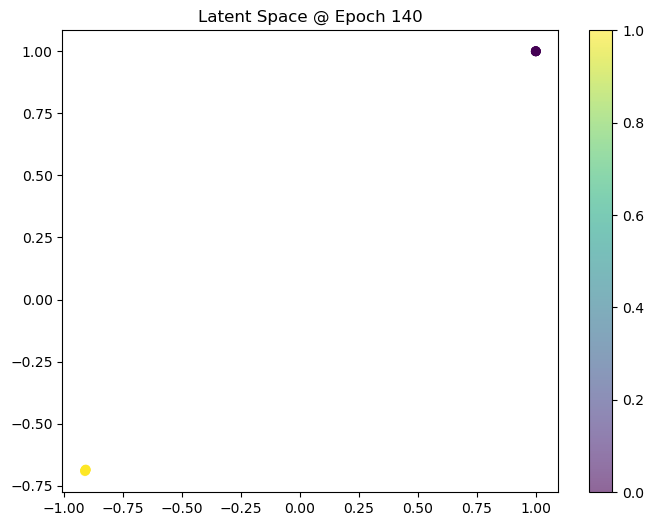

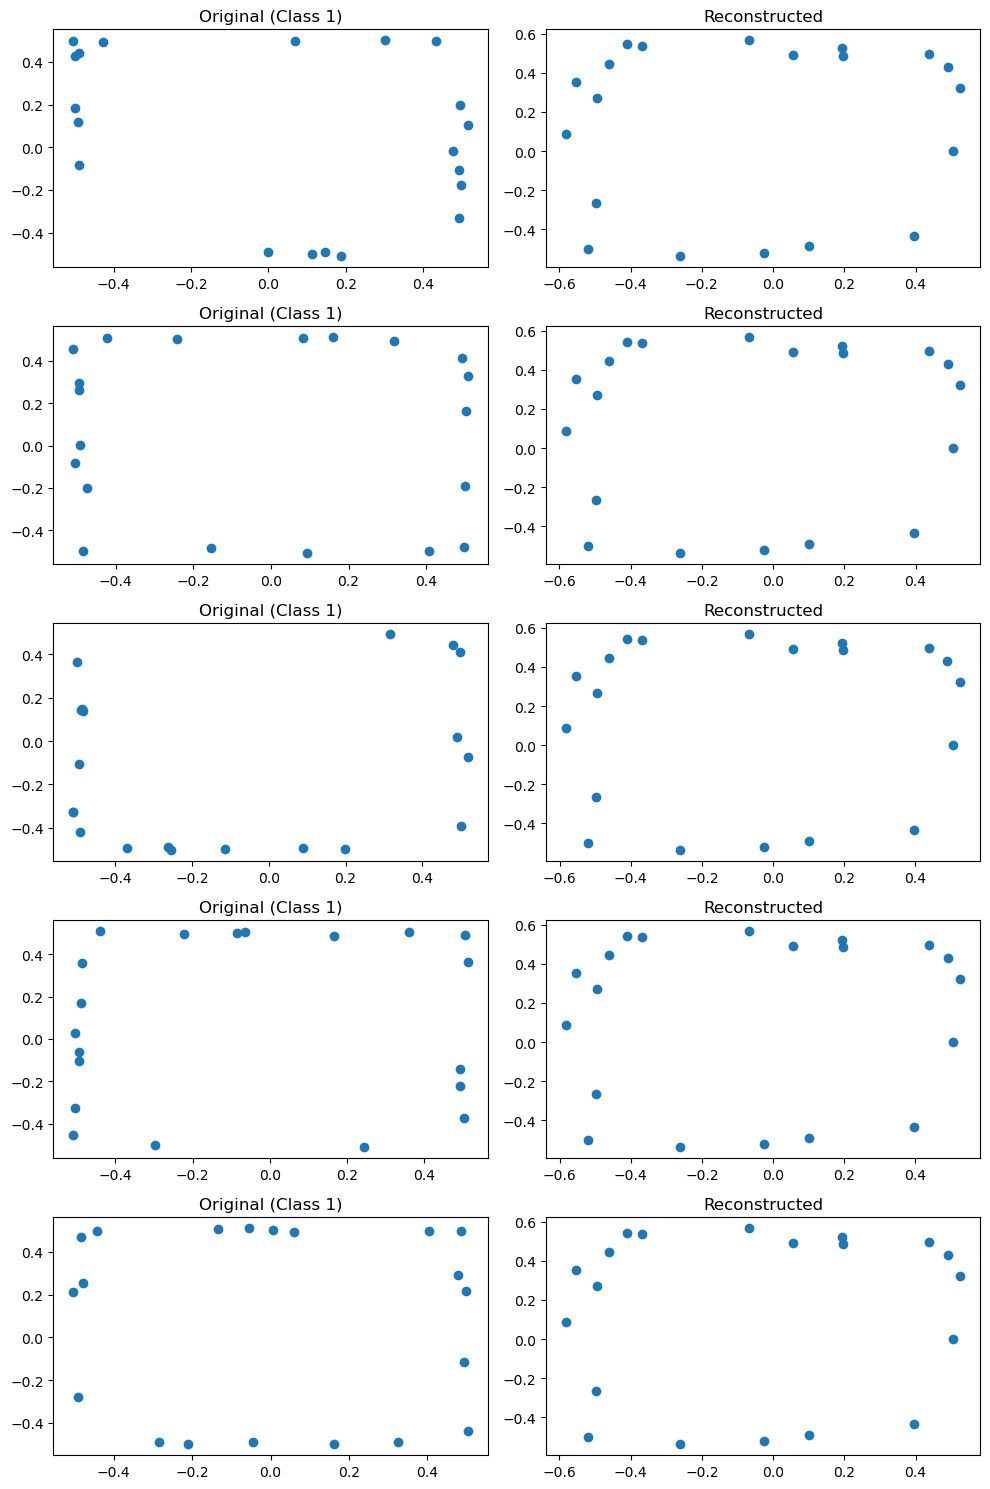

Epoch 140 | Loss: 0.7137 (Recon: 0.3567 Class: 0.0003)
Epoch 141 | Loss: 0.7065 (Recon: 0.3531 Class: 0.0003)
Epoch 142 | Loss: 0.7080 (Recon: 0.3539 Class: 0.0003)
Epoch 143 | Loss: 0.7073 (Recon: 0.3535 Class: 0.0003)
Epoch 144 | Loss: 0.7364 (Recon: 0.3681 Class: 0.0003)
Epoch 145 | Loss: 0.7122 (Recon: 0.3560 Class: 0.0003)
Epoch 146 | Loss: 0.6915 (Recon: 0.3456 Class: 0.0002)
Epoch 147 | Loss: 0.7090 (Recon: 0.3544 Class: 0.0002)
Epoch 148 | Loss: 0.6988 (Recon: 0.3493 Class: 0.0002)
Epoch 149 | Loss: 0.7268 (Recon: 0.3633 Class: 0.0002)


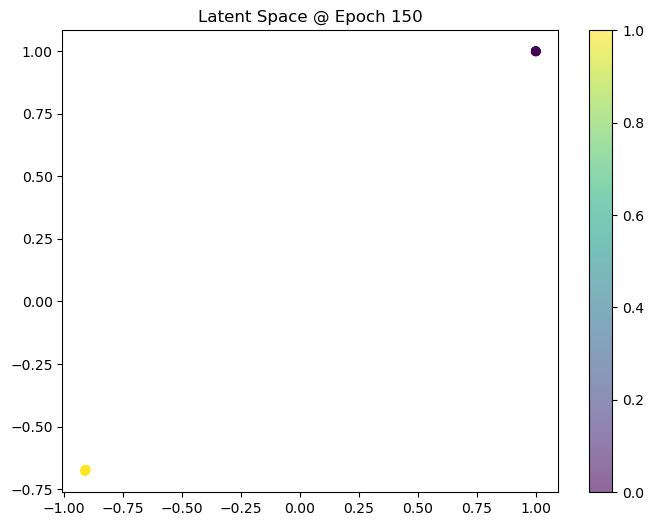

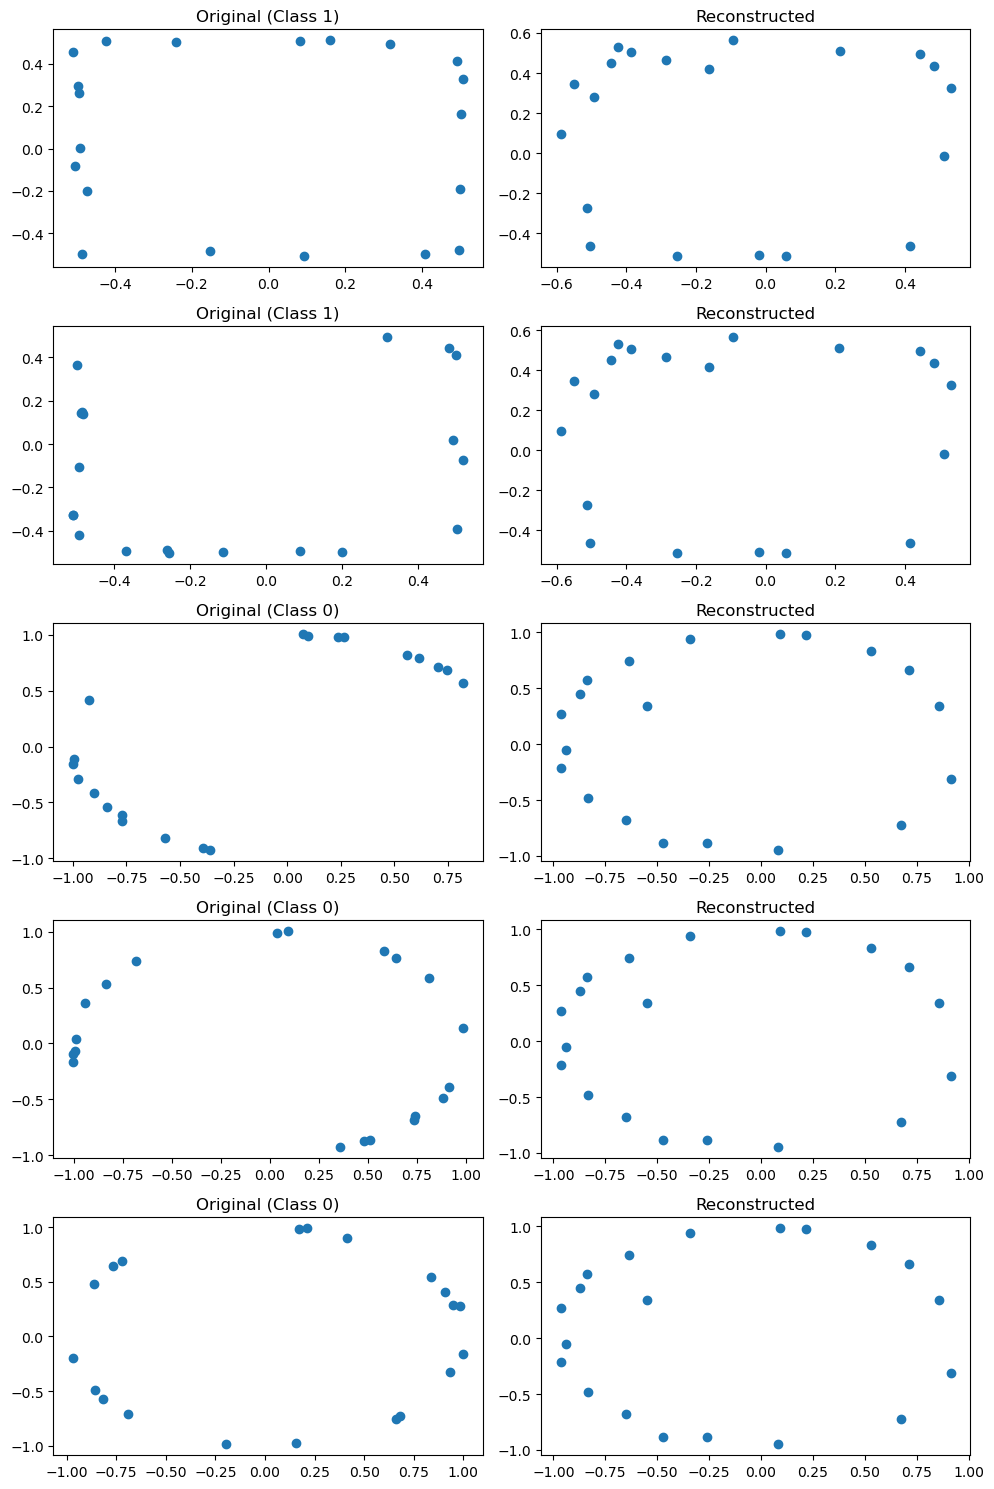

Epoch 150 | Loss: 0.7402 (Recon: 0.3700 Class: 0.0002)
Epoch 151 | Loss: 0.7197 (Recon: 0.3597 Class: 0.0002)
Epoch 152 | Loss: 0.7241 (Recon: 0.3619 Class: 0.0002)
Epoch 153 | Loss: 0.7193 (Recon: 0.3595 Class: 0.0002)
Epoch 154 | Loss: 0.7056 (Recon: 0.3527 Class: 0.0002)
Epoch 155 | Loss: 0.7025 (Recon: 0.3512 Class: 0.0002)
Epoch 156 | Loss: 0.7316 (Recon: 0.3657 Class: 0.0002)
Epoch 157 | Loss: 0.7158 (Recon: 0.3578 Class: 0.0002)
Epoch 158 | Loss: 0.7071 (Recon: 0.3534 Class: 0.0002)
Epoch 159 | Loss: 0.6890 (Recon: 0.3444 Class: 0.0002)


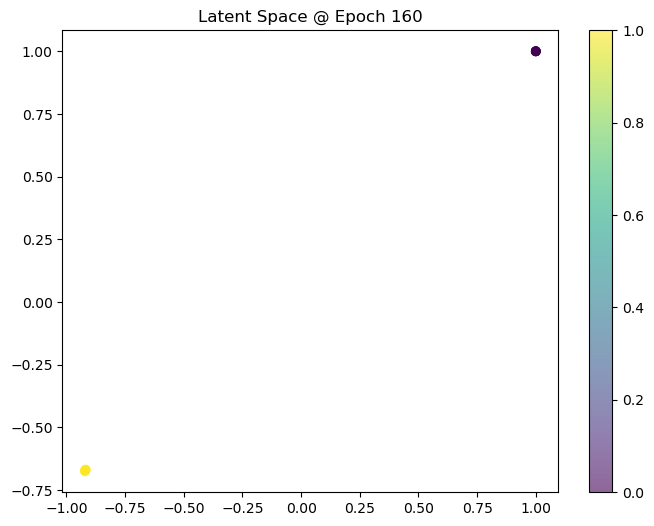

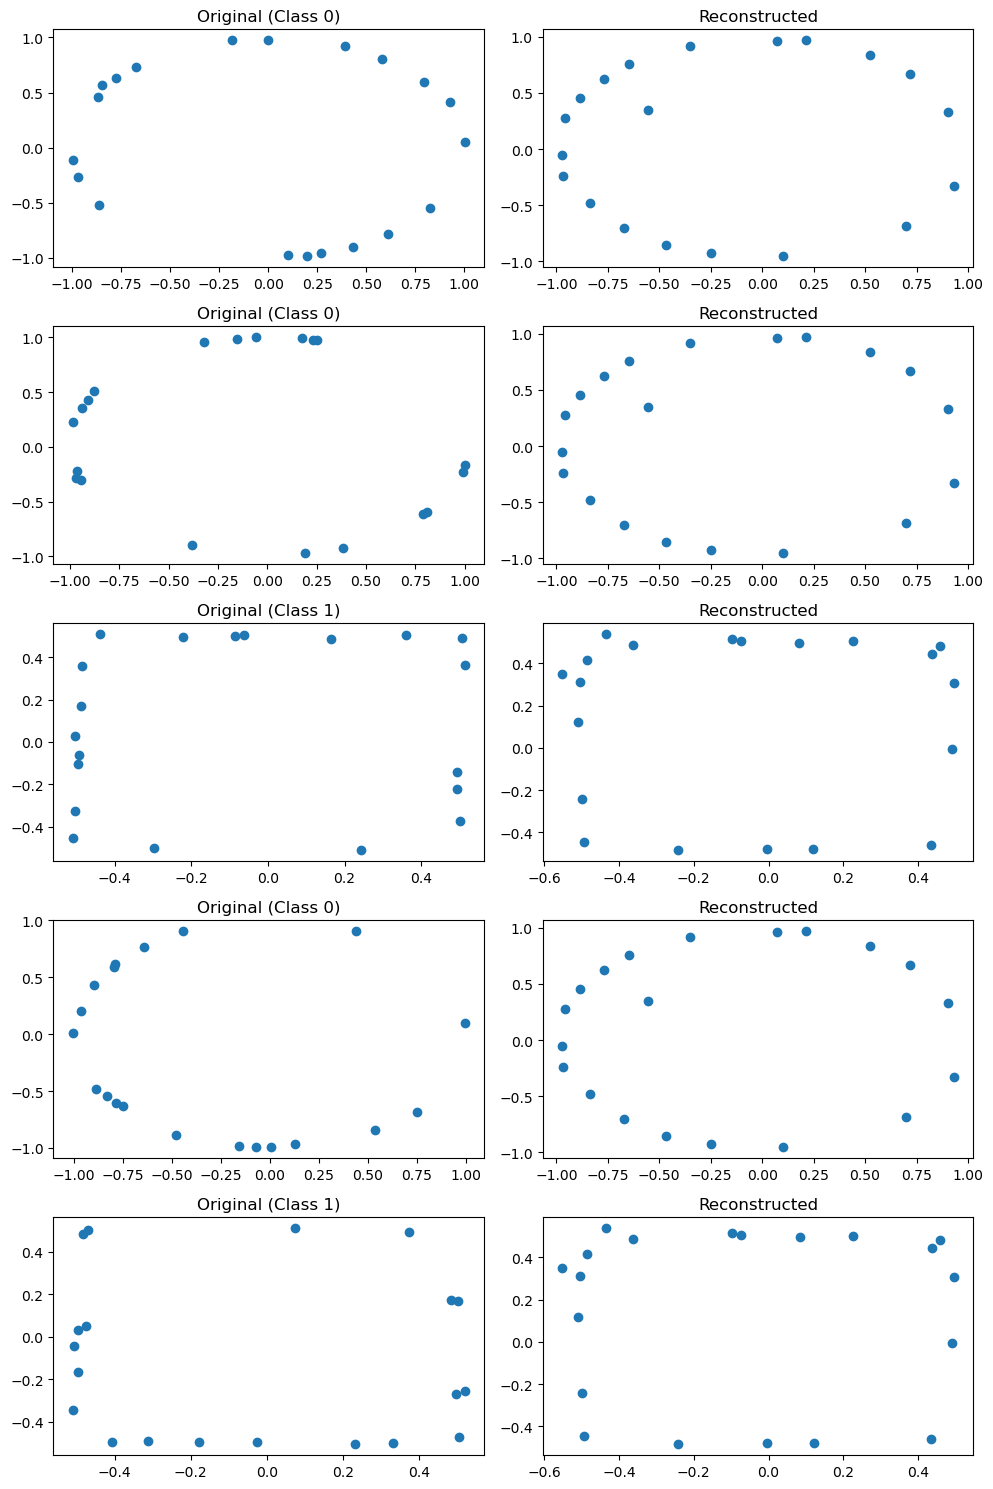

Epoch 160 | Loss: 0.6932 (Recon: 0.3465 Class: 0.0002)
Epoch 161 | Loss: 0.7021 (Recon: 0.3509 Class: 0.0002)
Epoch 162 | Loss: 0.6958 (Recon: 0.3478 Class: 0.0002)
Epoch 163 | Loss: 0.6910 (Recon: 0.3454 Class: 0.0002)
Epoch 164 | Loss: 0.6977 (Recon: 0.3488 Class: 0.0002)
Epoch 165 | Loss: 0.6891 (Recon: 0.3445 Class: 0.0002)
Epoch 166 | Loss: 0.6961 (Recon: 0.3480 Class: 0.0002)
Epoch 167 | Loss: 0.7150 (Recon: 0.3574 Class: 0.0002)
Epoch 168 | Loss: 0.7230 (Recon: 0.3614 Class: 0.0002)
Epoch 169 | Loss: 0.7010 (Recon: 0.3504 Class: 0.0002)


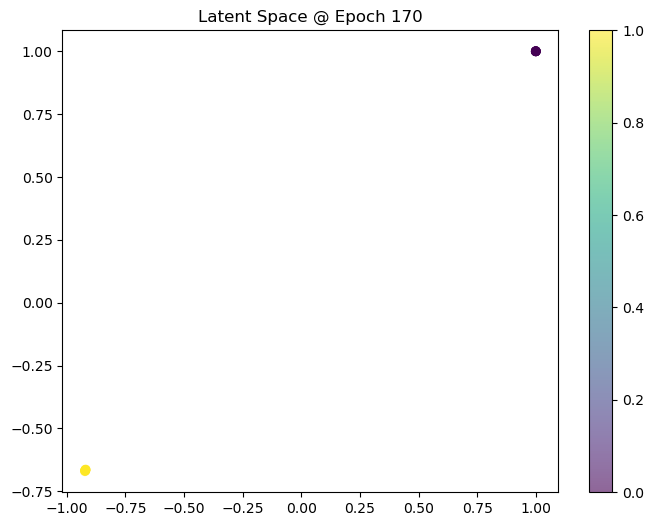

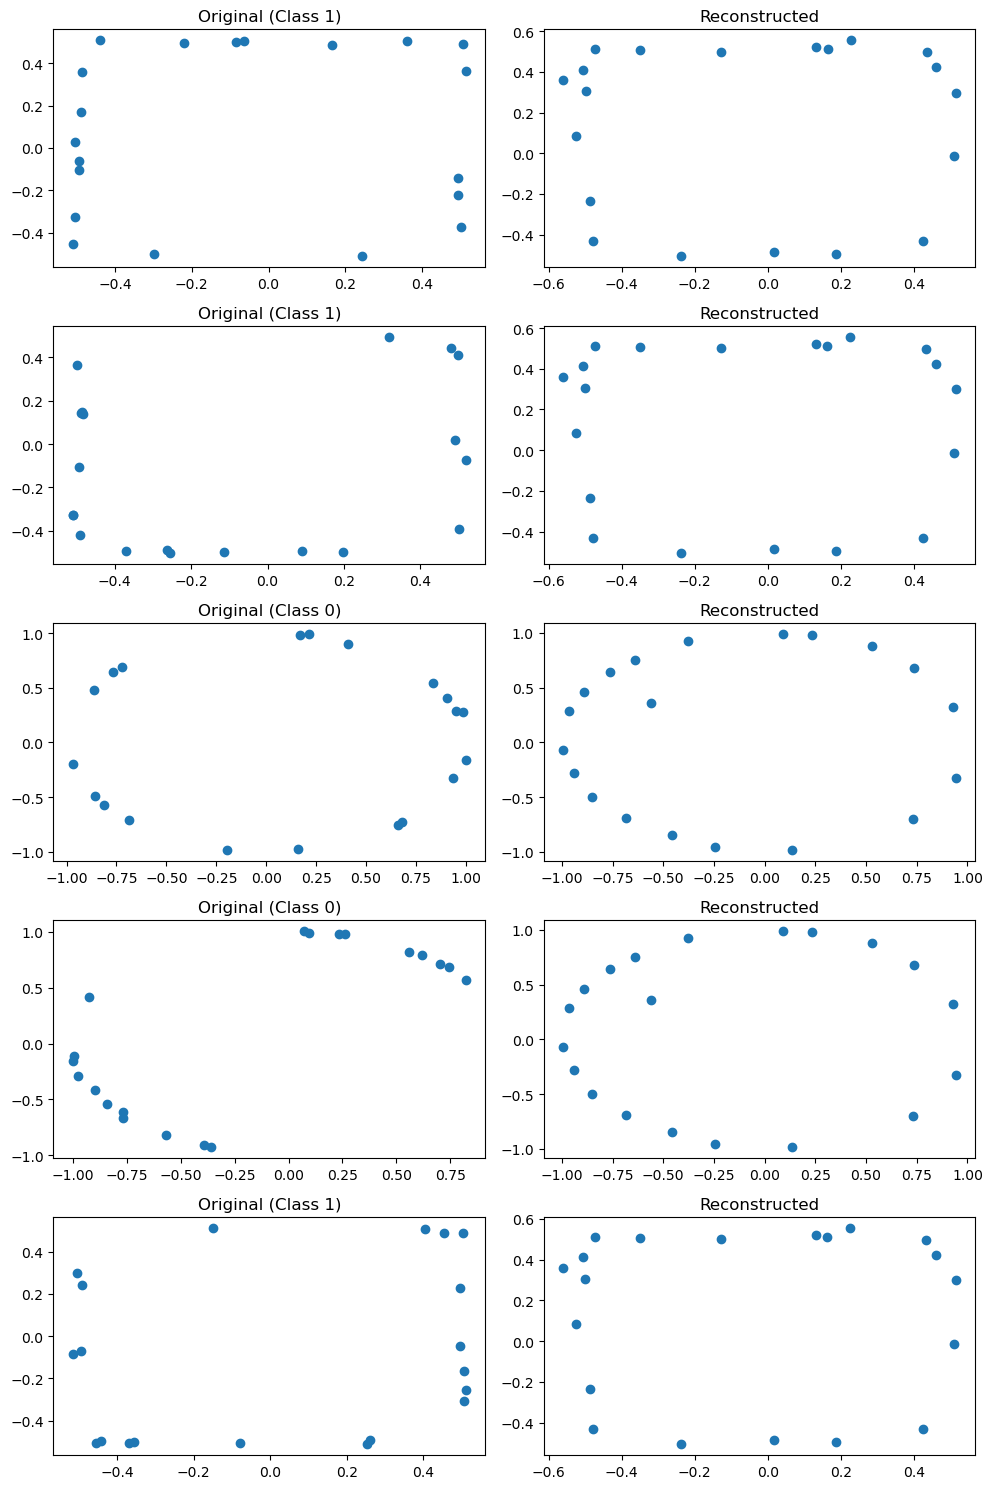

Epoch 170 | Loss: 0.7062 (Recon: 0.3530 Class: 0.0002)
Epoch 171 | Loss: 0.7028 (Recon: 0.3513 Class: 0.0002)
Epoch 172 | Loss: 0.6894 (Recon: 0.3446 Class: 0.0002)
Epoch 173 | Loss: 0.7045 (Recon: 0.3522 Class: 0.0002)
Epoch 174 | Loss: 0.7062 (Recon: 0.3530 Class: 0.0002)
Epoch 175 | Loss: 0.6958 (Recon: 0.3478 Class: 0.0002)
Epoch 176 | Loss: 0.6960 (Recon: 0.3479 Class: 0.0002)
Epoch 177 | Loss: 0.6966 (Recon: 0.3482 Class: 0.0002)
Epoch 178 | Loss: 0.7163 (Recon: 0.3581 Class: 0.0002)
Epoch 179 | Loss: 0.6959 (Recon: 0.3479 Class: 0.0002)


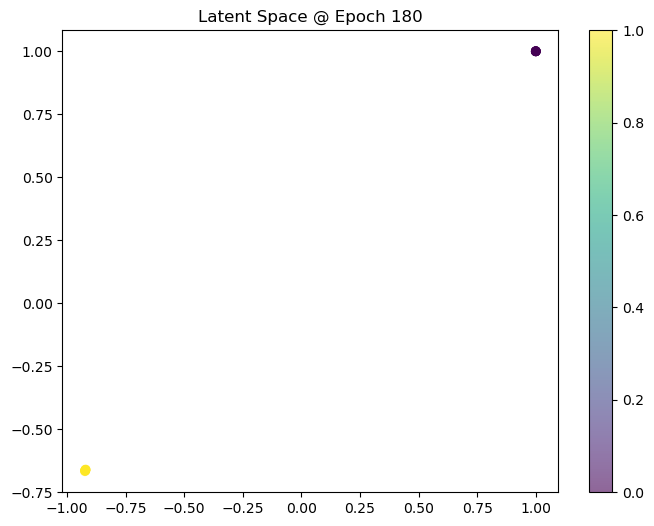

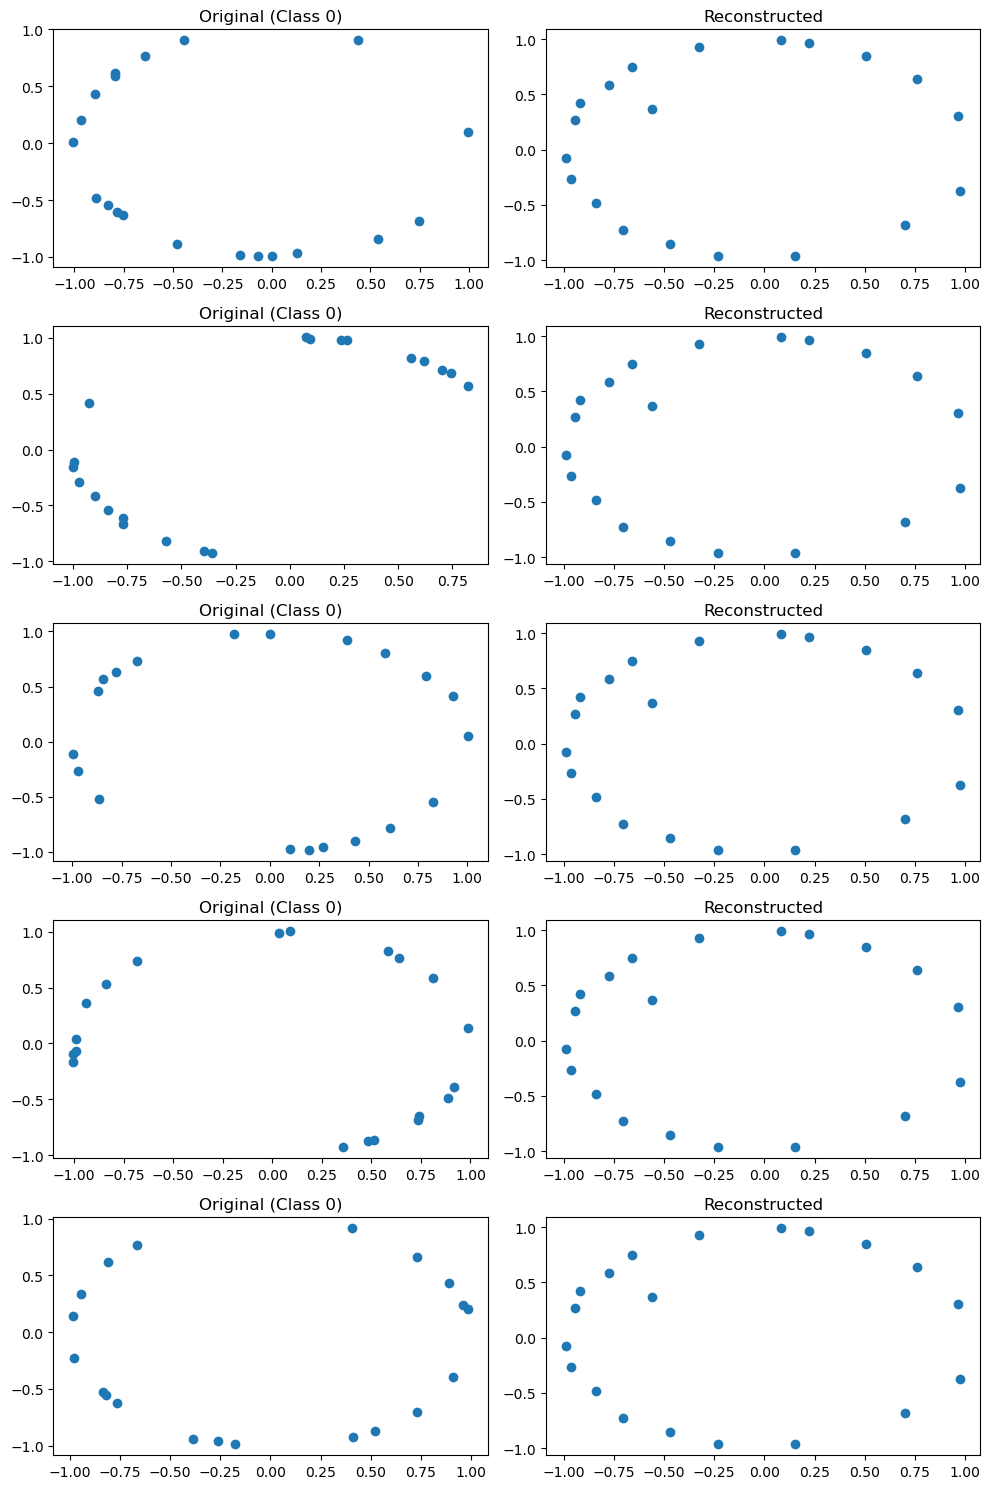

Epoch 180 | Loss: 0.6983 (Recon: 0.3491 Class: 0.0001)
Epoch 181 | Loss: 0.6828 (Recon: 0.3413 Class: 0.0001)
Epoch 182 | Loss: 0.7138 (Recon: 0.3568 Class: 0.0001)
Epoch 183 | Loss: 0.6948 (Recon: 0.3473 Class: 0.0001)
Epoch 184 | Loss: 0.6974 (Recon: 0.3486 Class: 0.0001)
Epoch 185 | Loss: 0.6865 (Recon: 0.3432 Class: 0.0001)
Epoch 186 | Loss: 0.6940 (Recon: 0.3469 Class: 0.0001)
Epoch 187 | Loss: 0.7074 (Recon: 0.3536 Class: 0.0001)
Epoch 188 | Loss: 0.7029 (Recon: 0.3514 Class: 0.0001)
Epoch 189 | Loss: 0.6895 (Recon: 0.3447 Class: 0.0001)


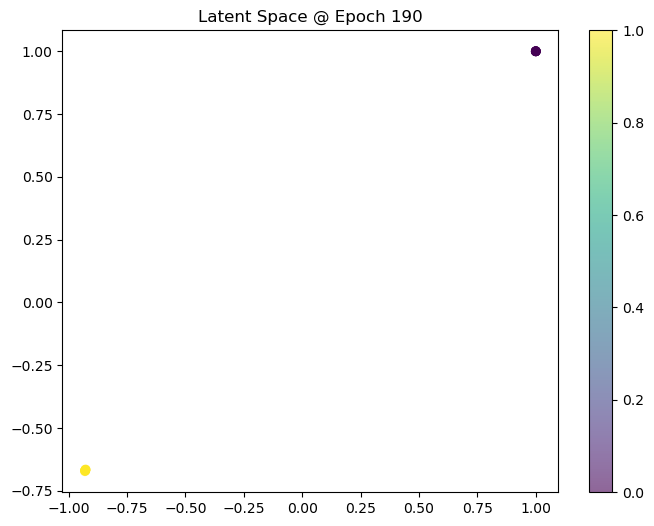

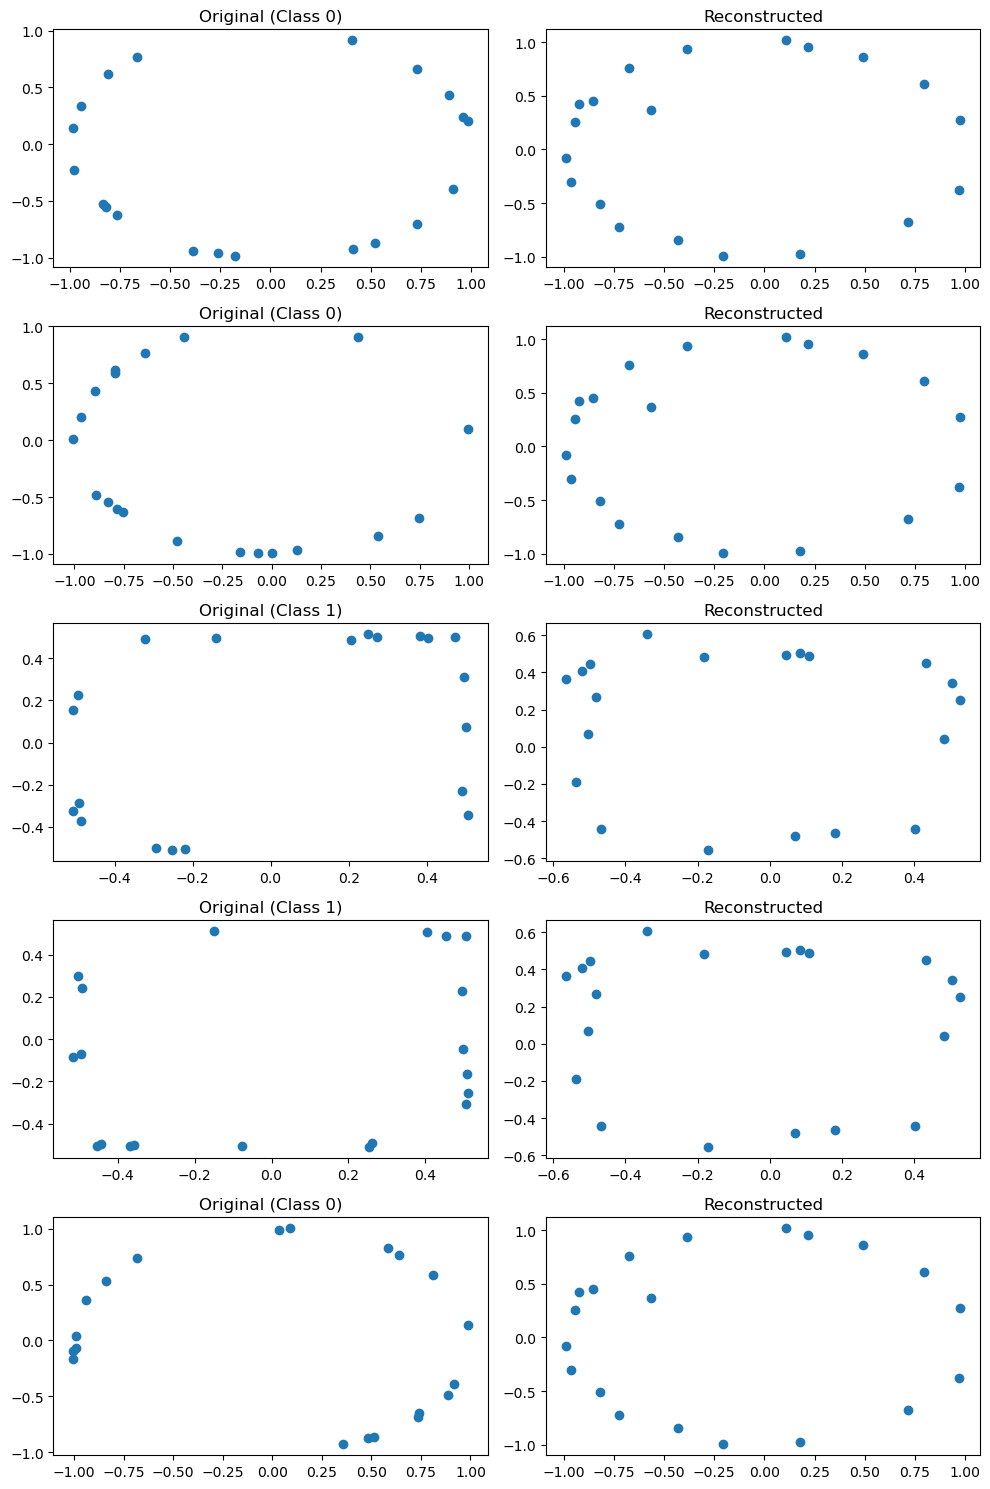

Epoch 190 | Loss: 0.7166 (Recon: 0.3582 Class: 0.0001)
Epoch 191 | Loss: 0.7058 (Recon: 0.3528 Class: 0.0001)
Epoch 192 | Loss: 0.6984 (Recon: 0.3491 Class: 0.0001)
Epoch 193 | Loss: 0.6984 (Recon: 0.3491 Class: 0.0001)
Epoch 194 | Loss: 0.7020 (Recon: 0.3509 Class: 0.0001)
Epoch 195 | Loss: 0.6950 (Recon: 0.3474 Class: 0.0001)
Epoch 196 | Loss: 0.6914 (Recon: 0.3456 Class: 0.0001)
Epoch 197 | Loss: 0.7105 (Recon: 0.3552 Class: 0.0001)
Epoch 198 | Loss: 0.7066 (Recon: 0.3533 Class: 0.0001)
Epoch 199 | Loss: 0.7221 (Recon: 0.3610 Class: 0.0001)


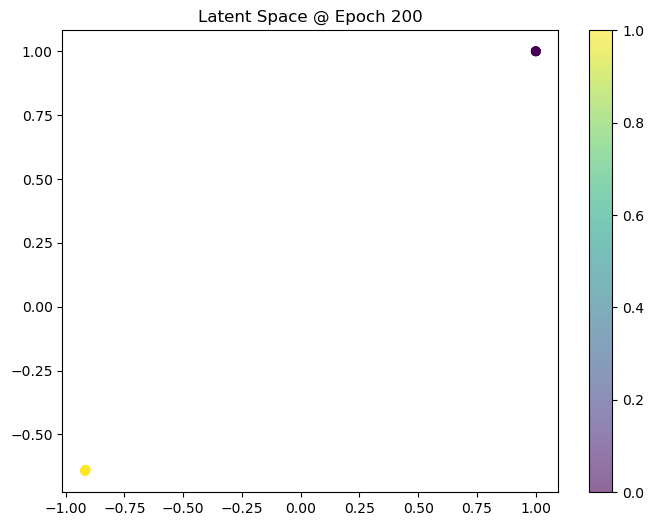

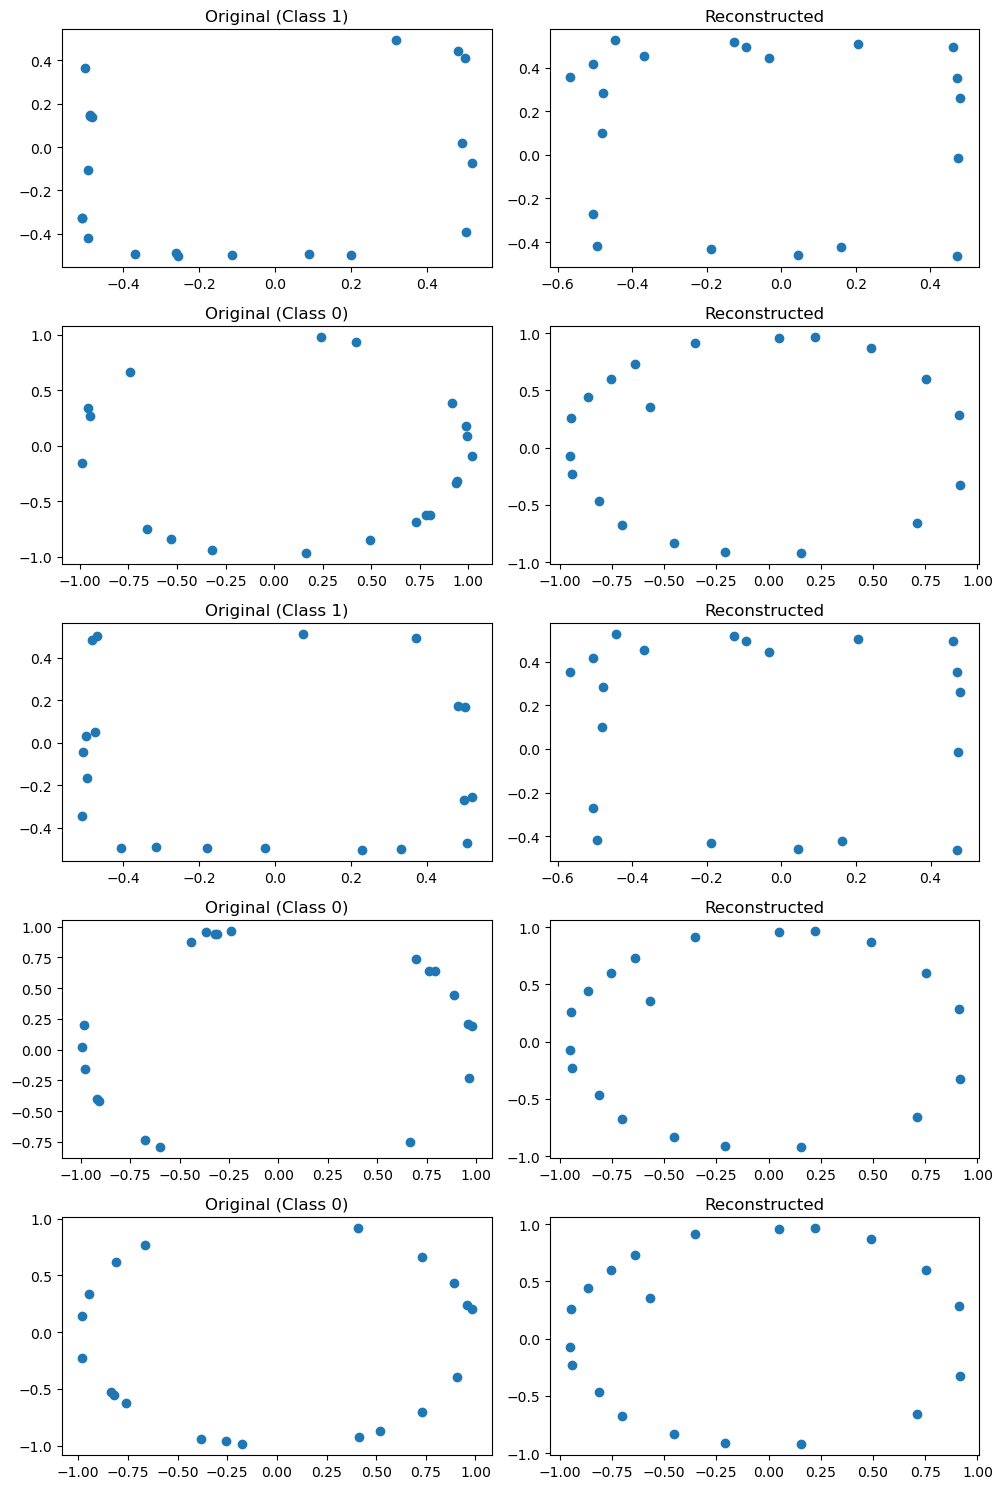

Epoch 200 | Loss: 0.7428 (Recon: 0.3714 Class: 0.0001)


In [103]:
# 2. Model Initialization
model = EGNN_Autoencoder(
    in_node_nf=2,          # Input node features (x,y coordinates)
    hidden_nf=16,         # Hidden layer size
    latent_dim=2,         # Latent space dimension
    n_layers=4,            # Number of EGNN layers
    num_nodes=20,          # Nodes per graph
    device=device
).to(device)

if __name__ == "__main__":
    # Generate data
    train_dataset = generate_dataset(num_graphs=100)
    val_dataset = generate_dataset(num_graphs=20)
    
    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8)
    
    # Start training
    train_model()

tensor([[-1.0000, -0.6100],
        [-0.6000, -0.2880],
        [-0.2000,  0.0340],
        [ 0.2000,  0.3560],
        [ 0.6000,  0.6780],
        [ 1.0000,  1.0000]]) 6


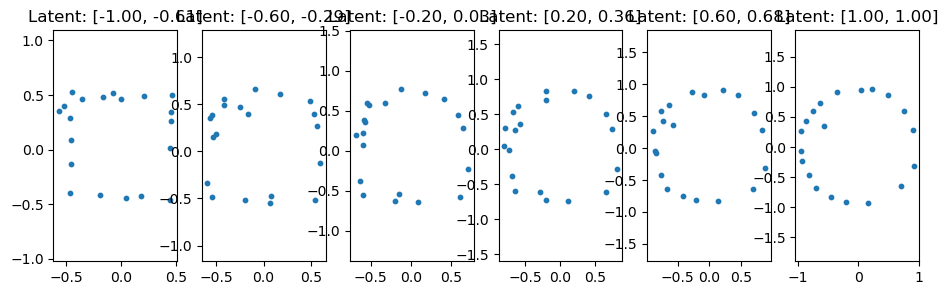

In [108]:
def visualize_latent_transition(model, start_point=(-1, 1), end_point=(1, 2.5), num_steps=5):
    # Create linear interpolation in latent space
    z_start = torch.tensor(start_point, dtype=torch.float32)
    z_end = torch.tensor(end_point, dtype=torch.float32)
    
    # Generate interpolation points
    alphas = torch.linspace(0, 1, num_steps)
    z_samples = torch.stack([z_start + alpha*(z_end - z_start) for alpha in alphas])
    # Reconstruct samples
    model.eval()
    with torch.no_grad():
        z_samples = z_samples.to(device)
        reconstructions = model.decode(z_samples, z_samples.size(0))
        print(z_samples, z_samples.size(0))
    # Plot
    plt.figure(figsize=(15, 3))
    for i in range(num_steps):
        plt.subplot(1, num_steps+2, i+1)
        plt.scatter(reconstructions[i,:,0].cpu(), reconstructions[i,:,1].cpu(), s=10)
        plt.title(f"Latent: [{z_samples[i,0]:.2f}, {z_samples[i,1]:.2f}]")
        plt.axis('equal')
    
# Usage
visualize_latent_transition(model, 
                           start_point=(-1, -0.61), 
                           end_point=(1, 1),
                           num_steps=6)

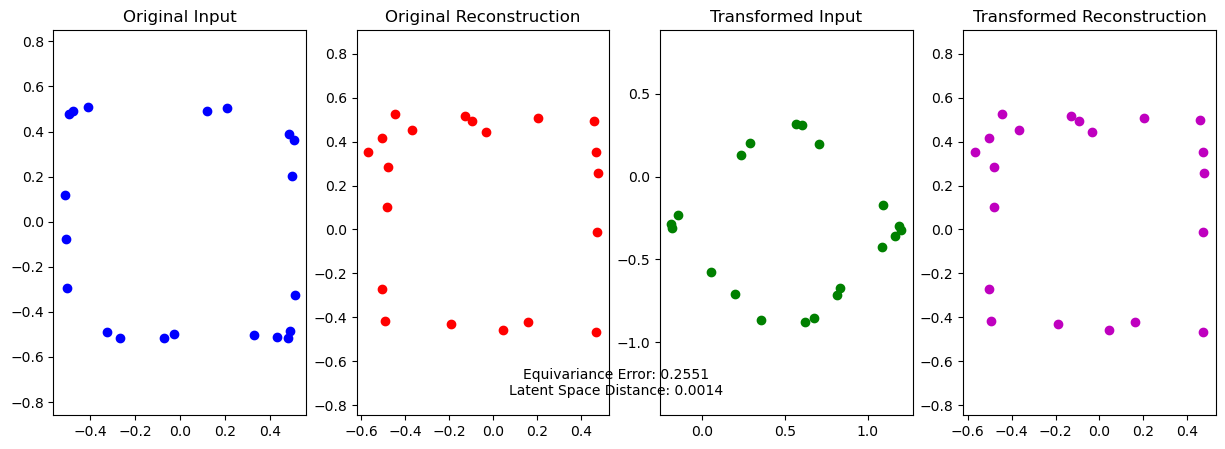

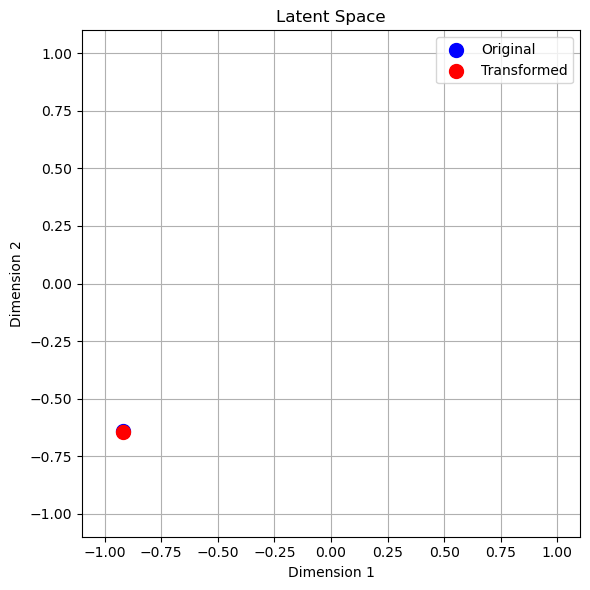

In [127]:
import matplotlib.pyplot as plt
import numpy as np

def test_equivariance_and_visualize(model, device,lab):
    # Create test sample
    test_data = generate_graph(label=lab)
    test_data = test_data.to(device)
    
    # Create transformed version (rotation + translation)
    theta = np.pi/4
    translation = torch.tensor([0.5, -0.3], device=device, dtype=torch.float32)  # Add dtype
    
    # Create rotation matrix with matching dtype
    rot_mat = torch.tensor([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ], device=device, dtype=test_data.pos.dtype)  # Match input dtype
    
    # Apply transformation
    transformed_data = test_data.clone()
    transformed_data.pos = (test_data.pos @ rot_mat.T) + translation
    transformed_data.x = transformed_data.pos
    
    # Get model outputs
    model.eval()
    with torch.no_grad():
        # Original
        recon_orig, z_orig, _ = model(test_data)
        
        # Transformed
        recon_trans, z_trans, _ = model(transformed_data)
        
        # Apply inverse transformation to reconstruction
        recon_trans_inv = (recon_trans - translation) @ rot_mat
    
    # Convert to numpy for plotting
    orig_pos = test_data.pos.cpu().numpy()
    trans_pos = transformed_data.pos.cpu().numpy()
    recon_orig = recon_orig.squeeze().cpu().numpy()
    recon_trans = recon_trans.squeeze().cpu().numpy()
    recon_trans_inv = recon_trans_inv.squeeze().cpu().numpy()
    
    # Calculate metrics
    equivariance_error = np.mean((recon_trans_inv - recon_orig)**2)
    latent_distance = torch.norm(z_orig - z_trans).item()

    # Create figure
    plt.figure(figsize=(15, 5))
    
    # Original input and reconstruction
    plt.subplot(1, 4, 1)
    plt.scatter(orig_pos[:,0], orig_pos[:,1], c='b')
    plt.title("Original Input")
    plt.axis('equal')
    
    plt.subplot(1, 4, 2)
    plt.scatter(recon_orig[:,0], recon_orig[:,1], c='r')
    plt.title("Original Reconstruction")
    plt.axis('equal')
    
    # Transformed input and reconstruction
    plt.subplot(1, 4, 3)
    plt.scatter(trans_pos[:,0], trans_pos[:,1], c='g')
    plt.title("Transformed Input")
    plt.axis('equal')
    
    plt.subplot(1, 4, 4)
    plt.scatter(recon_trans[:,0], recon_trans[:,1], c='m')
    plt.title("Transformed Reconstruction")
    plt.axis('equal')
    
    # Add metrics text
    plt.figtext(0.5, 0.15, 
                f"Equivariance Error: {equivariance_error:.4f}\n"
                f"Latent Space Distance: {latent_distance:.4f}",
                ha="center")
    
    # Plot latent space
    plt.figure(figsize=(6, 6))
    plt.xlim([-1.1, 1.1])
    plt.ylim([-1.1, 1.1])
    plt.scatter(z_orig[0,0].cpu(), z_orig[0,1].cpu(), 
                s=100, c='b', label='Original')
    plt.scatter(z_trans[0,0].cpu(), z_trans[0,1].cpu(), 
                s=100, c='r', label='Transformed')
    plt.title("Latent Space")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Usage
test_equivariance_and_visualize(model, device,1)

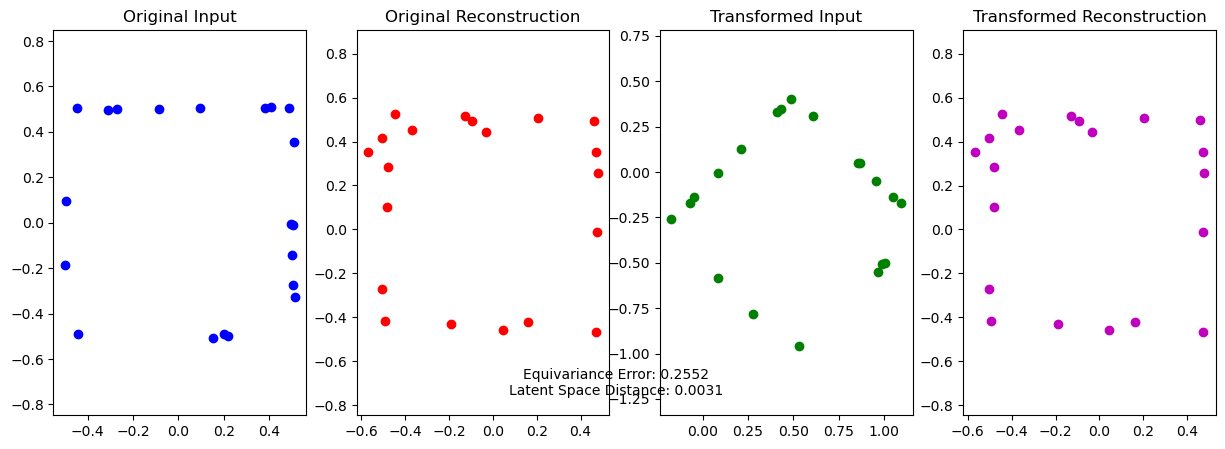

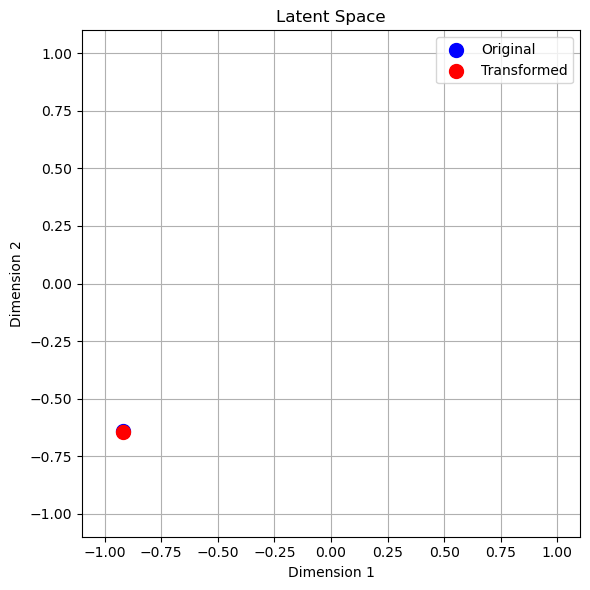

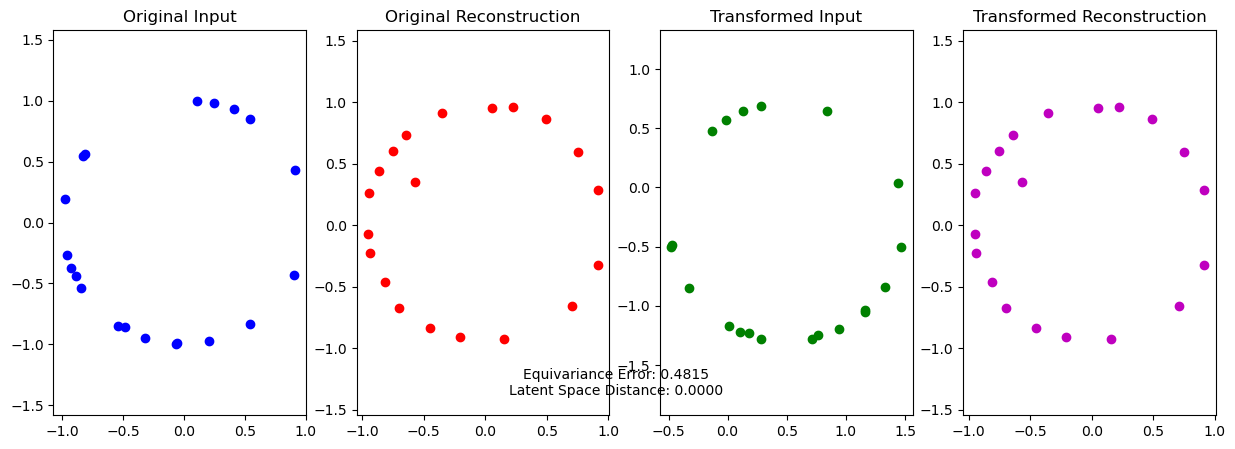

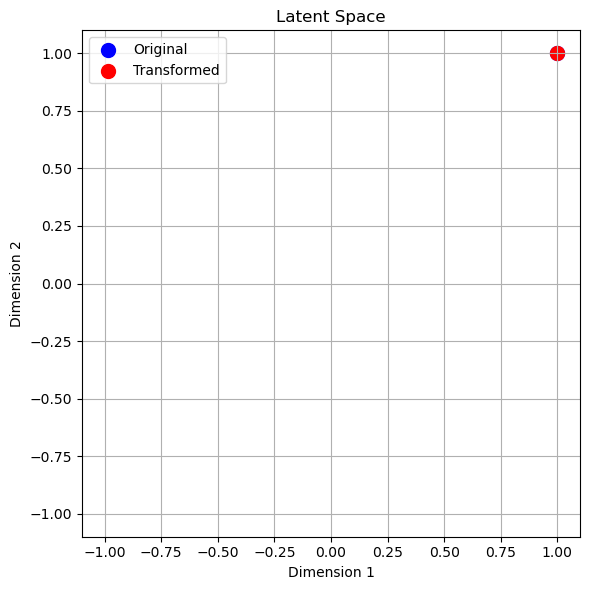

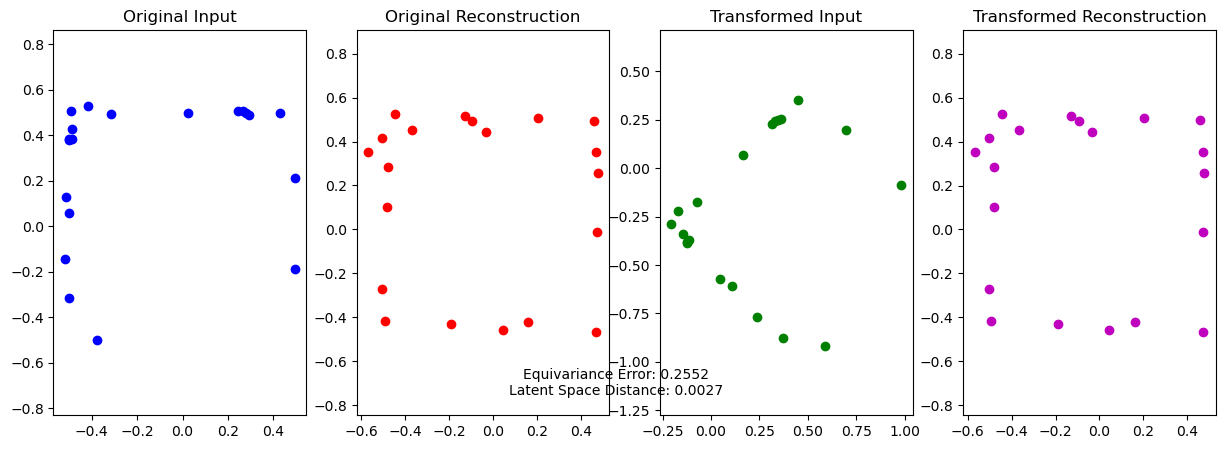

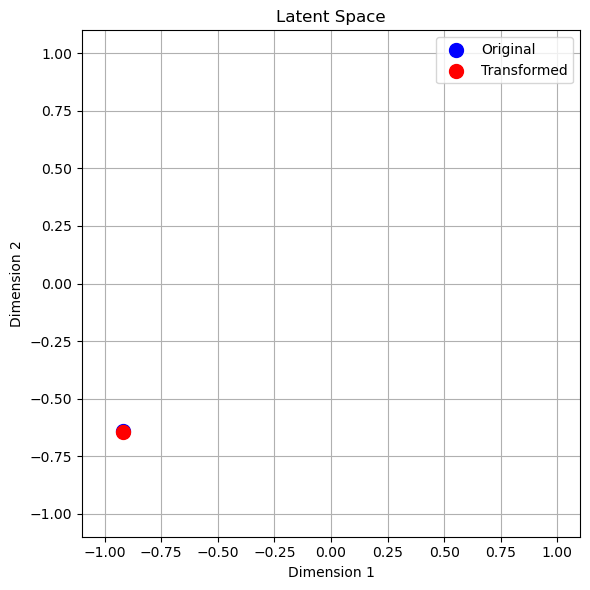

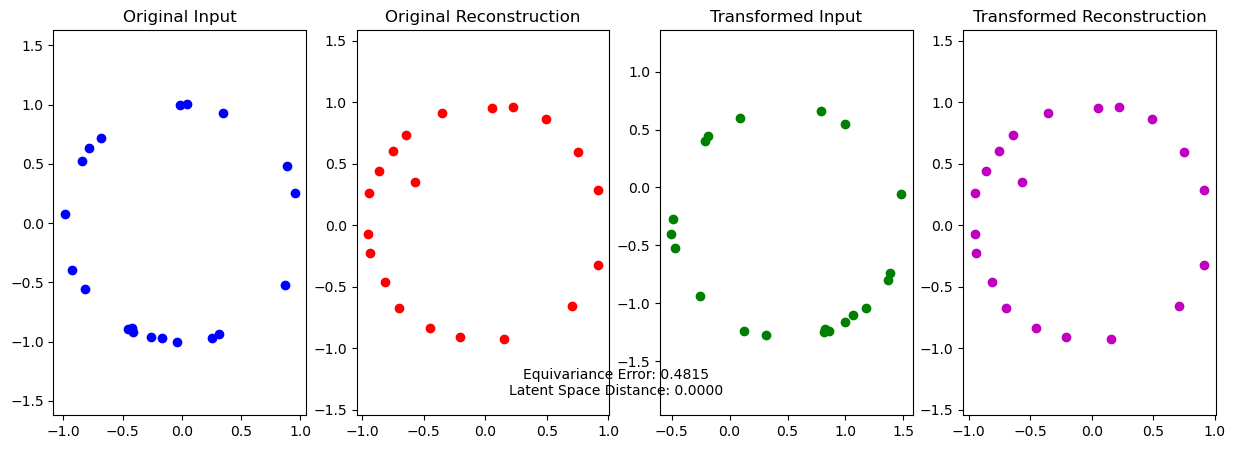

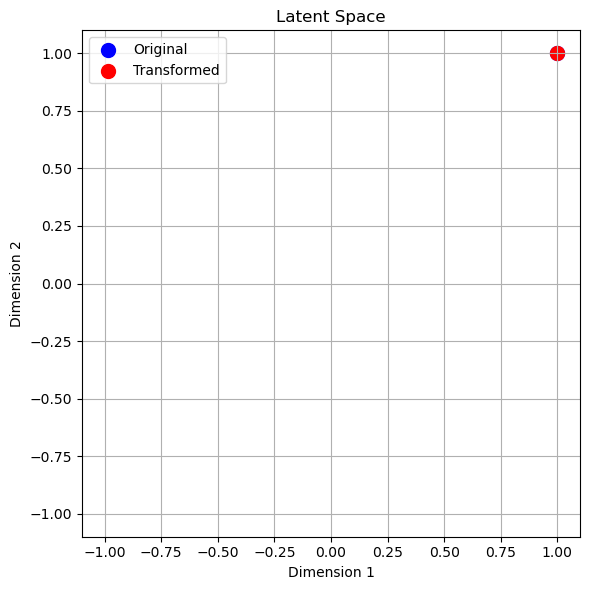

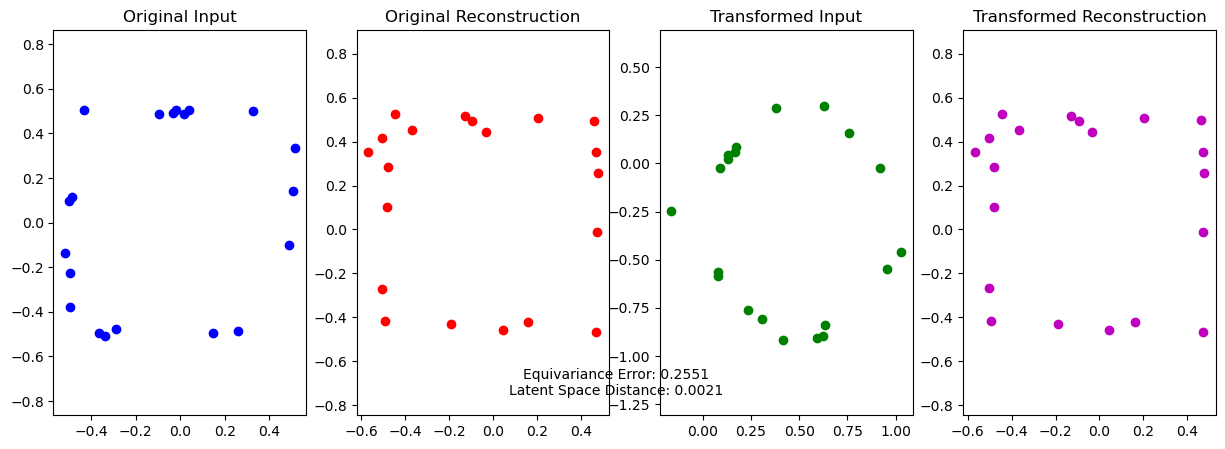

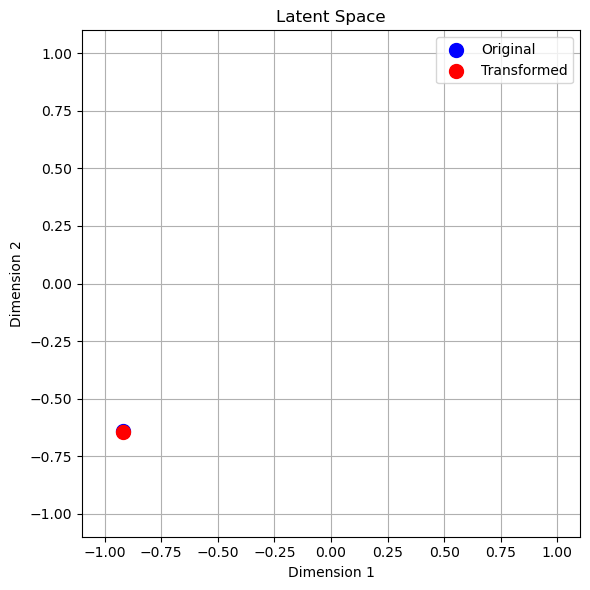

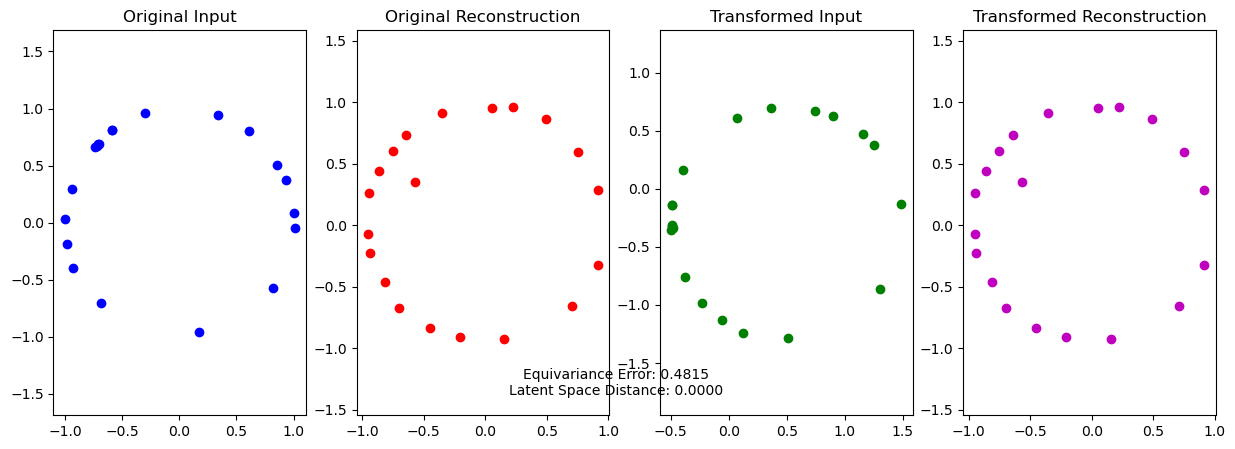

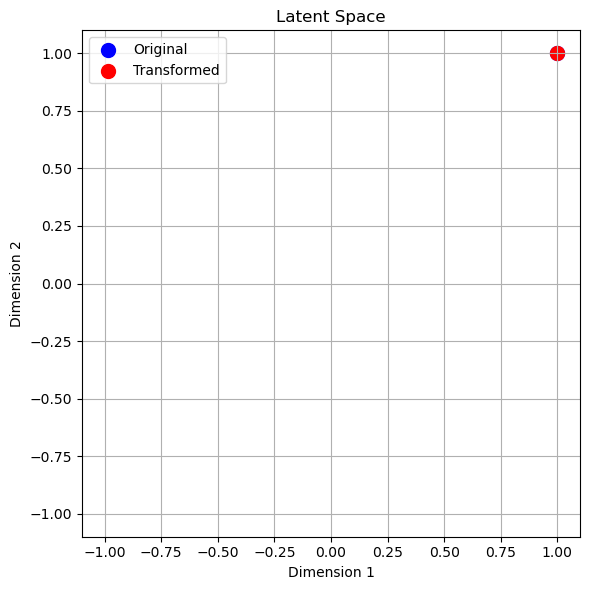

In [128]:
for i in [1,0,1,0,1,0]:
    test_equivariance_and_visualize(model, device,i)

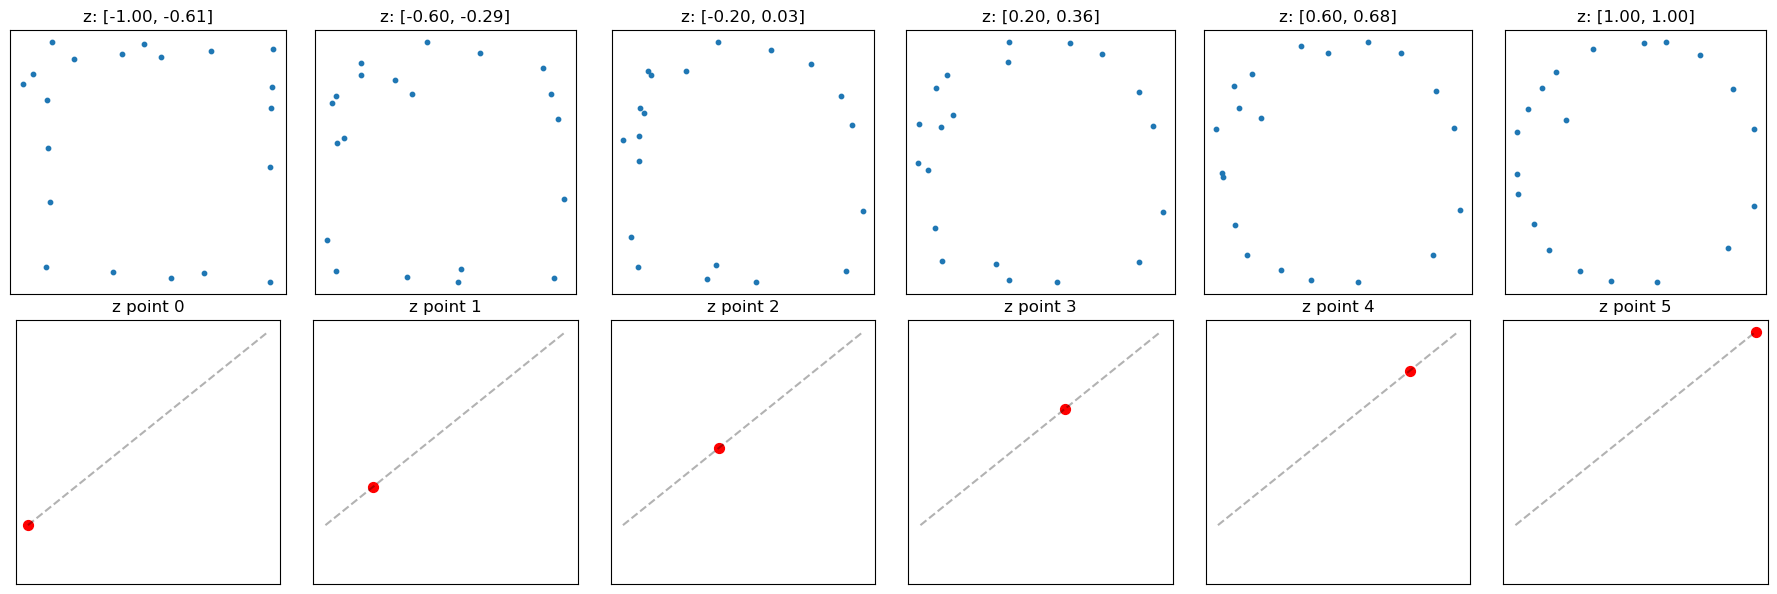

In [131]:
import matplotlib.pyplot as plt
import torch

import matplotlib.pyplot as plt
import torch

def visualize_latent_transition(model, start_point=(-1, 1), end_point=(1, 2.5), num_steps=5):
    # Create linear interpolation in latent space
    z_start = torch.tensor(start_point, dtype=torch.float32)
    z_end = torch.tensor(end_point, dtype=torch.float32)

    # Generate interpolation points
    alphas = torch.linspace(0, 1, num_steps)
    z_samples = torch.stack([z_start + alpha * (z_end - z_start) for alpha in alphas])

    # Reconstruct samples
    model.eval()
    with torch.no_grad():
        z_samples = z_samples.to(device)
        reconstructions = model.decode(z_samples, z_samples.size(0))

    # Plotting
    fig = plt.figure(figsize=(3 * num_steps, 6))

    # Top row: reconstructions
    for i in range(num_steps):
        ax = plt.subplot(2, num_steps, i + 1)
        ax.scatter(reconstructions[i, :, 0].cpu(), reconstructions[i, :, 1].cpu(), s=10)
        ax.set_title(f"z: [{z_samples[i, 0]:.2f}, {z_samples[i, 1]:.2f}]")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')

    # Bottom row: latent position per sample
    for i in range(num_steps):
        ax = plt.subplot(2, num_steps, num_steps + i + 1)
        # Plot full latent interpolation line
        ax.plot(z_samples[:, 0].cpu(), z_samples[:, 1].cpu(), 'k--', alpha=0.3)
        # Highlight current z point
        ax.scatter(z_samples[i, 0].cpu(), z_samples[i, 1].cpu(), color='red', s=50)
        ax.set_xlim([-1.1, 1.1])
        ax.set_ylim([-1.1, 1.1])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        ax.set_title(f"z point {i}")

    plt.tight_layout()
    plt.show()
visualize_latent_transition(model, 
                           start_point=(-1, -0.61), 
                           end_point=(1, 1),
                           num_steps=6)